In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import sweetviz as sv
import warnings 
warnings.filterwarnings("ignore")
import seaborn as sns
# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'
# Larger scale for plots in notebooks
sns.set_context('notebook')


sns.set_palette("colorblind")
sns.set(font_scale = 1.3)
sns.set_style("whitegrid")

In [3]:
survey_vitals = pd.read_csv("survey_vitals_clean.csv").drop(columns = 'Unnamed: 0').drop_duplicates()
eval_med = pd.read_csv("evaluation_medical_clean.csv").drop(columns = 'Unnamed: 0').drop_duplicates()
history_env = pd.read_csv("history_env_clean.csv").drop(columns = 'Unnamed: 0').drop_duplicates()

In [4]:
print(survey_vitals.shape)
print(eval_med.shape)
print(history_env.shape)

(9458, 10)
(8263, 7)
(5472, 16)


In [5]:
print(survey_vitals.shape)
print(eval_med.shape)
print(history_env.shape)

(9458, 10)
(8263, 7)
(5472, 16)


# Clustering based on geopoint data

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import seaborn as sns
from sklearn.impute import SimpleImputer

In [7]:
survey_vitals.head()

,objectId,marriageStatus,occupation,educationLevel,latitude,longitude,city,province,age,sex
0,XHCkKebF4a,single,Ama de casa,lessThanprimary,18.912087,-70.743801,NaN,NaN,34.0,female
1,ITCa1BkIiK,single,Ama de casa,someHighSchool,18.913084,-70.744104,NaN,NaN,52.0,female
2,AKjkw9A25J,single,Other,someHighSchool,18.913084,-70.744016,NaN,NaN,39.0,male
3,jk3fDkMvN9,single,Ama de casa,lessThanprimary,18.913325,-70.744557,NaN,NaN,39.0,female
4,pPgDn3kfGL,single,Estudiante,someHighSchool,18.913523,-70.745053,NaN,NaN,23.0,male


In [8]:
geo_loc = survey_vitals.loc[:, ["latitude", "longitude"]]

In [9]:
scaler = StandardScaler()

In [10]:
transformed_geo = scaler.fit_transform(geo_loc)

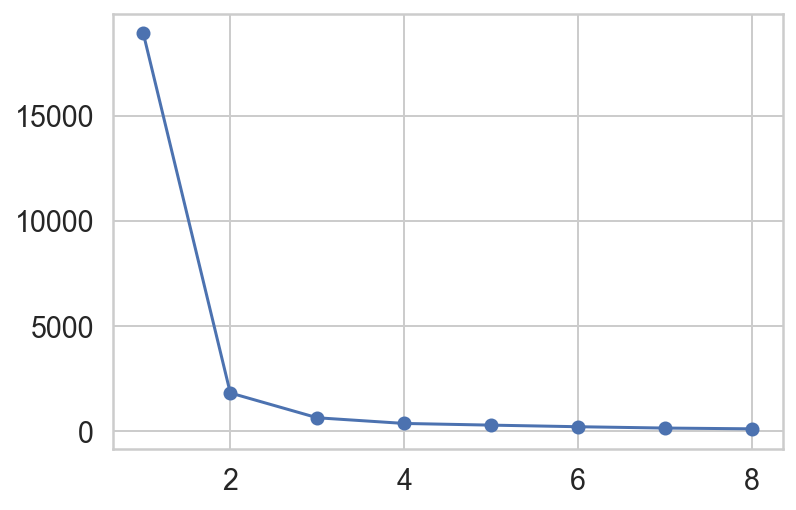

In [11]:
inertias = []
num_clusters = [1,2,3,4,5,6,7,8]
for k in num_clusters:
    model = KMeans(n_clusters = k, random_state = 42)
    model.fit(transformed_geo)
    inertias.append(model.inertia_)

plt.plot(num_clusters, inertias, "-o")

In [12]:
model_KMeans =  KMeans(n_clusters = 4, random_state = 42)
labels = model_KMeans.fit_predict(transformed_geo)
labels

array([1, 1, 1, ..., 2, 2, 2])

In [13]:
survey_vitals["clustersByLoc"] = list(labels)
survey_vitals.head()

,objectId,marriageStatus,occupation,educationLevel,latitude,longitude,city,province,age,sex,clustersByLoc
0,XHCkKebF4a,single,Ama de casa,lessThanprimary,18.912087,-70.743801,NaN,NaN,34.0,female,1
1,ITCa1BkIiK,single,Ama de casa,someHighSchool,18.913084,-70.744104,NaN,NaN,52.0,female,1
2,AKjkw9A25J,single,Other,someHighSchool,18.913084,-70.744016,NaN,NaN,39.0,male,1
3,jk3fDkMvN9,single,Ama de casa,lessThanprimary,18.913325,-70.744557,NaN,NaN,39.0,female,1
4,pPgDn3kfGL,single,Estudiante,someHighSchool,18.913523,-70.745053,NaN,NaN,23.0,male,1


In [14]:
def province_clean(cluster):
    if cluster == 0:
        return "Lavega"
    elif cluster == 1:
        return "San Pedro de Macoris"
    elif cluster == 2:
        return "Santiago"
    else:
        return "San Pedro de Macoris/North"

In [15]:
survey_vitals = survey_vitals.drop(columns = ["city", "province"], axis = 1)
survey_vitals["province"] = survey_vitals["clustersByLoc"].apply(province_clean)

In [16]:
survey_vitals.head()

,objectId,marriageStatus,occupation,educationLevel,latitude,longitude,age,sex,clustersByLoc,province
0,XHCkKebF4a,single,Ama de casa,lessThanprimary,18.912087,-70.743801,34.0,female,1,San Pedro de Macoris
1,ITCa1BkIiK,single,Ama de casa,someHighSchool,18.913084,-70.744104,52.0,female,1,San Pedro de Macoris
2,AKjkw9A25J,single,Other,someHighSchool,18.913084,-70.744016,39.0,male,1,San Pedro de Macoris
3,jk3fDkMvN9,single,Ama de casa,lessThanprimary,18.913325,-70.744557,39.0,female,1,San Pedro de Macoris
4,pPgDn3kfGL,single,Estudiante,someHighSchool,18.913523,-70.745053,23.0,male,1,San Pedro de Macoris


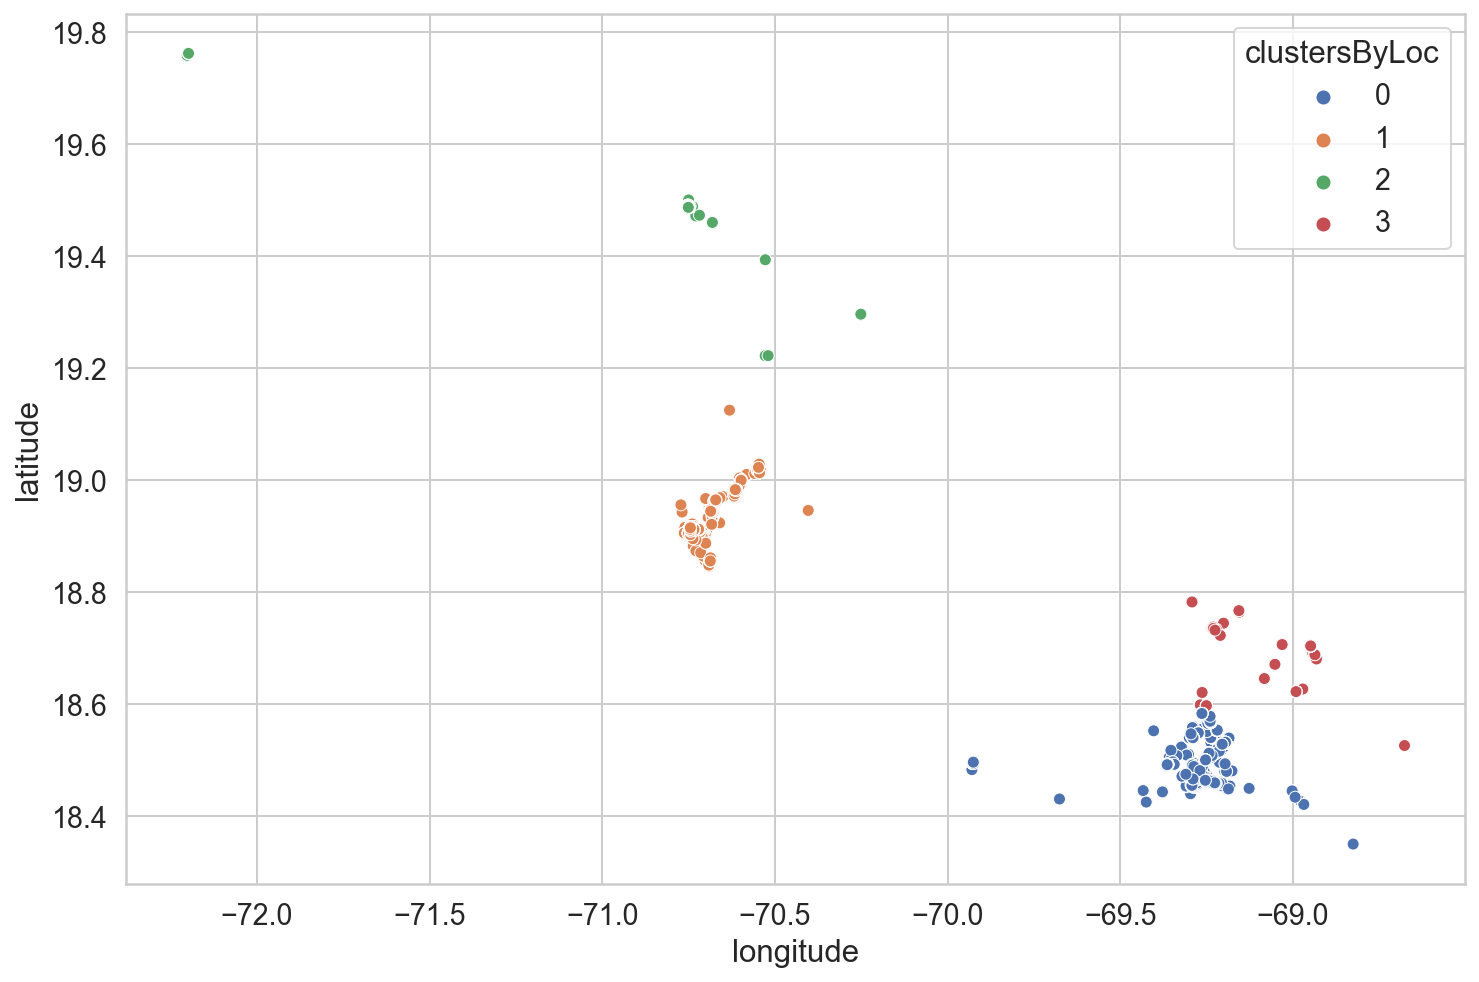

In [17]:
plt.figure(figsize = (12,8))
ax = sns.scatterplot(data = survey_vitals, x = "longitude", y = "latitude", hue = "clustersByLoc", palette = "deep")

# Dealing with missing values: survey_vitals

### 1. survey_vitals

In [18]:
survey_vitals.shape

(9458, 10)

In [19]:
# delete marriagestatus

In [20]:
survey_vitals.isna().sum()

objectId             0
marriageStatus    1597
occupation           0
educationLevel    1486
latitude             0
longitude            0
age                482
sex                  0
clustersByLoc        0
province             0
dtype: int64

In [21]:
# filling missing values in marriageStatus column based on distribution
s = survey_vitals.marriageStatus.value_counts(normalize = True)
s

single        0.452487
free_union    0.340287
married       0.127465
widow         0.042743
concubine     0.037018
Name: marriageStatus, dtype: float64

In [22]:
missing = survey_vitals["marriageStatus"].isnull()
survey_vitals.loc[missing, "marriageStatus"] = np.random.choice(s.index, size=len(survey_vitals[missing]),p=s.values)

In [23]:
survey_vitals.head()

,objectId,marriageStatus,occupation,educationLevel,latitude,longitude,age,sex,clustersByLoc,province
0,XHCkKebF4a,single,Ama de casa,lessThanprimary,18.912087,-70.743801,34.0,female,1,San Pedro de Macoris
1,ITCa1BkIiK,single,Ama de casa,someHighSchool,18.913084,-70.744104,52.0,female,1,San Pedro de Macoris
2,AKjkw9A25J,single,Other,someHighSchool,18.913084,-70.744016,39.0,male,1,San Pedro de Macoris
3,jk3fDkMvN9,single,Ama de casa,lessThanprimary,18.913325,-70.744557,39.0,female,1,San Pedro de Macoris
4,pPgDn3kfGL,single,Estudiante,someHighSchool,18.913523,-70.745053,23.0,male,1,San Pedro de Macoris


In [24]:
age_dict = survey_vitals.groupby("marriageStatus")["age"].median().to_dict()
age_dict

{'concubine': 38.0,
 'free_union': 37.0,
 'married': 47.0,
 'single': 29.0,
 'widow': 66.0}

In [25]:
unknown_age = survey_vitals["age"].isnull()
survey_vitals.loc[unknown_age, "age"] = survey_vitals.loc[unknown_age, "marriageStatus"].map(age_dict)

In [26]:
survey_vitals.isna().sum()

objectId             0
marriageStatus       0
occupation           0
educationLevel    1486
latitude             0
longitude            0
age                  0
sex                  0
clustersByLoc        0
province             0
dtype: int64

### Predicting educationLevel missing values

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

In [28]:
train_data = survey_vitals.dropna().drop(columns = ["latitude", "longitude", "clustersByLoc", "objectId"])
X_train = train_data.drop(columns = "educationLevel")
y_train = train_data["educationLevel"]
X_test = survey_vitals.loc[survey_vitals.educationLevel.isnull()].drop(columns = ["latitude", "longitude", "clustersByLoc", "objectId", "educationLevel"])

In [29]:
num_attribs = list(X_train.select_dtypes(include = [np.number]))
cat_attribs = list(X_train.select_dtypes(exclude = [np.number]))

In [30]:
numeric_transformer = Pipeline([
    ("imp", SimpleImputer(strategy = "mean")),
    ("scale", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imp", SimpleImputer(strategy = "most_frequent")),
    ("onehot", OneHotEncoder(drop = "if_binary"))
])

variable_trans_pipeline = ColumnTransformer([
    ("num", numeric_transformer, num_attribs),
    ("cat", categorical_transformer, cat_attribs)
])


prepared_train_X = variable_trans_pipeline.fit_transform(X_train)

ValueError: Wrong input for parameter `drop`. Expected 'first', None or array of objects, got <class 'str'>

In [ ]:
X_test_prepared = variable_trans_pipeline.transform(X_test)

In [ ]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state=42)
k_neigh_model = KNeighborsClassifier()
svc_model = SVC(gamma="scale",kernel="rbf", random_state = 42)

In [ ]:
voting_model = VotingClassifier([
    ("k_nearest", k_neigh_model), 
    ("SVC", svc_model), 
    ("random_forest", rf_model),
], voting = "hard", weights=[1,1,1])

In [ ]:
voting_model = voting_model.fit(prepared_train_X,y_train)

In [ ]:
accuracy = voting_model.score(prepared_train_X, y_train)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
y_test_pred = voting_model.predict(X_test_prepared)

In [ ]:
y_test_pred

In [ ]:
survey_vitals.loc[survey_vitals.educationLevel.isnull(), "educationLevel"] = y_test_pred

In [ ]:
survey_vitals.isna().sum()

In [ ]:
sv_report_survey_vitals = sv.analyze([survey_vitals, "Survey_vitals"])
sv_report_survey_vitals.show_notebook()

### 2. eval_med

In [ ]:
eval_med.shape

In [ ]:
eval_med.isna().sum()

In [ ]:
values = {"marriageStatus": , "educationLevel": , "age": survey_vitals.age.mean()}

In [ ]:
sv_report_eval_med = sv.analyze([eval_med, "Eval_med"])
sv_report_eval_med.show_notebook()

### 3. history_env

In [31]:
history_env.shape

(5472, 16)

In [32]:
history_env["numberofChildrenLivinginHouseUndertheAgeof5"] = history_env["numberofChildrenLivinginHouseUndertheAgeof5"].astype(str)

In [33]:
history_env.dtypes

objectId                                       object
yearsLivedinThisHouse                          object
waterAccess                                    object
typeofWaterdoyoudrink                          object
latrineAccess                                  object
conditionoFloorinyourhouse                     object
conditionoRoofinyourhouse                      object
medicalproblemswheredoyougo                    object
dentalproblemswheredoyougo                     object
biggestproblemofcommunity                      object
timesperweektrashcollected                     object
wheretrashleftbetweenpickups                   object
numberofIndividualsLivingintheHouse             int64
numberofChildrenLivinginHouseUndertheAgeof5    object
houseownership                                 object
bathroomAccess                                 object
dtype: object

In [34]:
history_env.isna().sum()

objectId                                          0
yearsLivedinThisHouse                            28
waterAccess                                     103
typeofWaterdoyoudrink                            54
latrineAccess                                  2228
conditionoFloorinyourhouse                      116
conditionoRoofinyourhouse                       139
medicalproblemswheredoyougo                       0
dentalproblemswheredoyougo                        0
biggestproblemofcommunity                         0
timesperweektrashcollected                        0
wheretrashleftbetweenpickups                      0
numberofIndividualsLivingintheHouse               0
numberofChildrenLivinginHouseUndertheAgeof5       0
houseownership                                  219
bathroomAccess                                 2719
dtype: int64

                                             |                                             | [  0%]   00:00 ->…


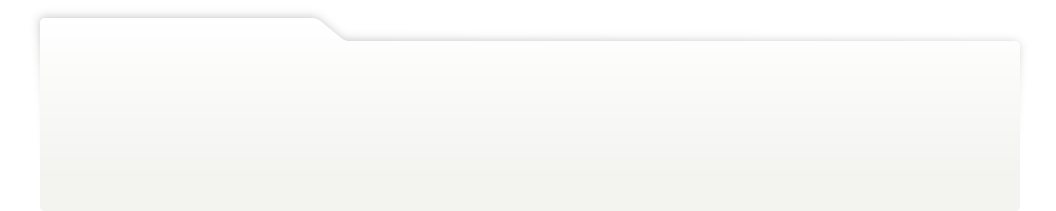
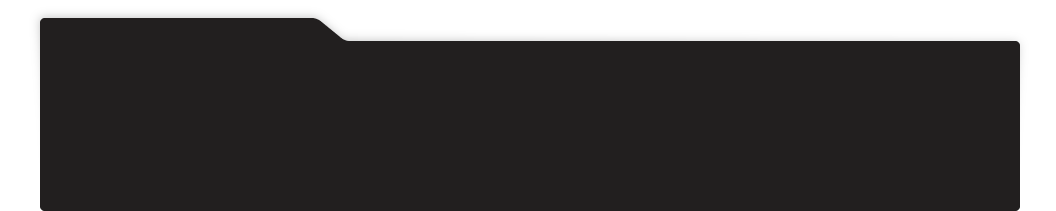
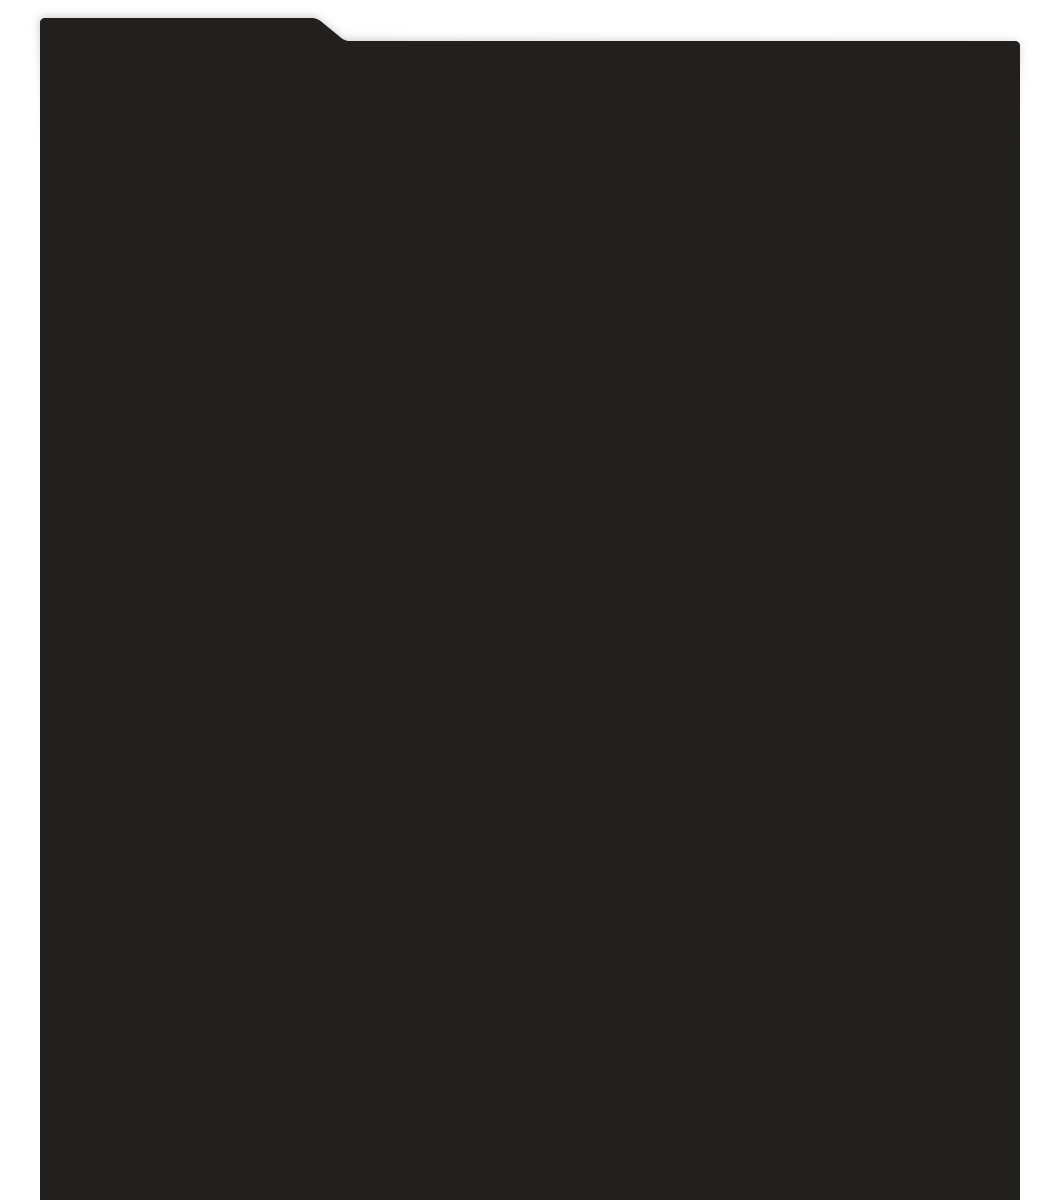
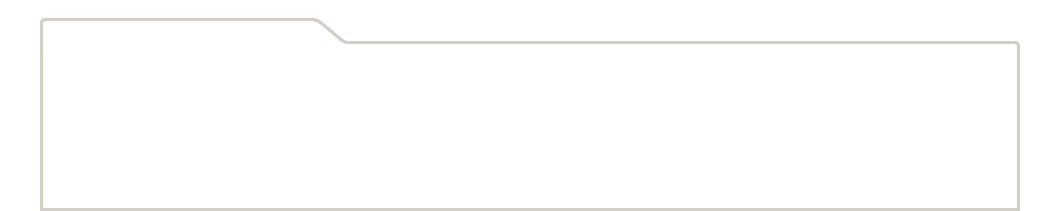
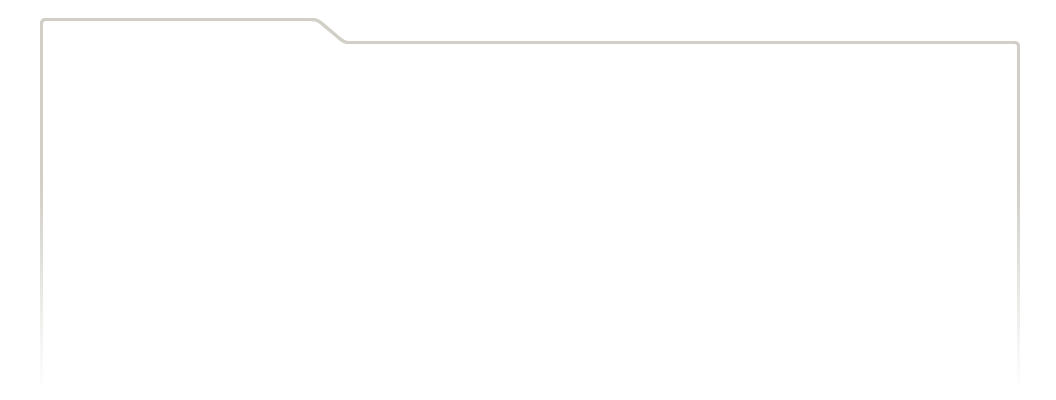
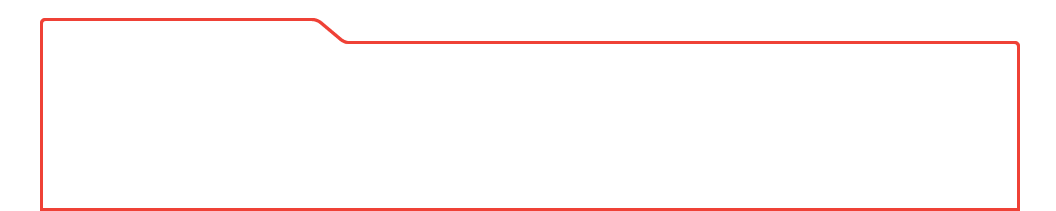
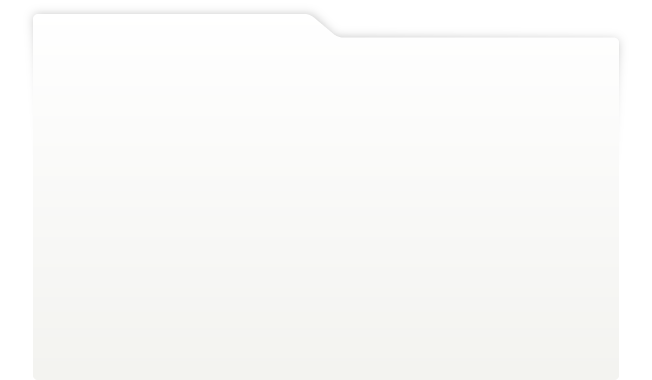
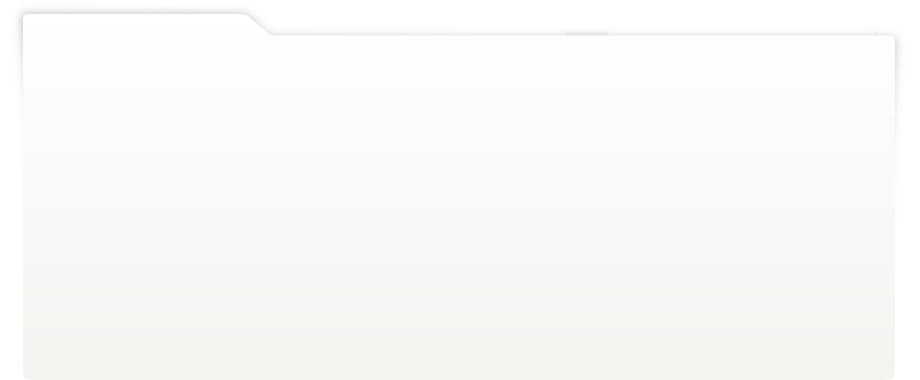
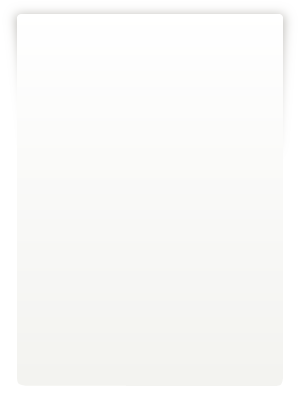
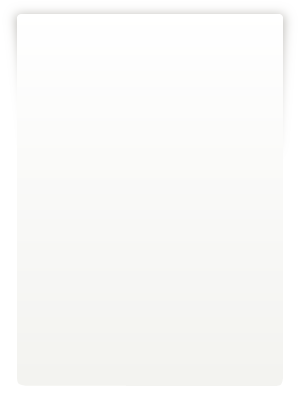
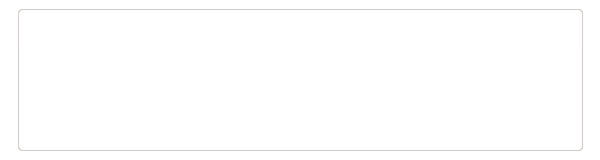
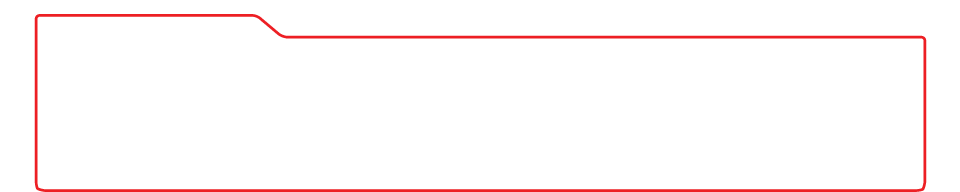
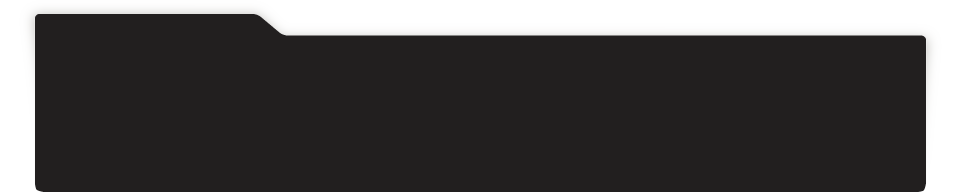
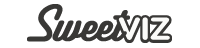
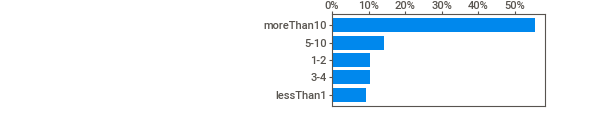
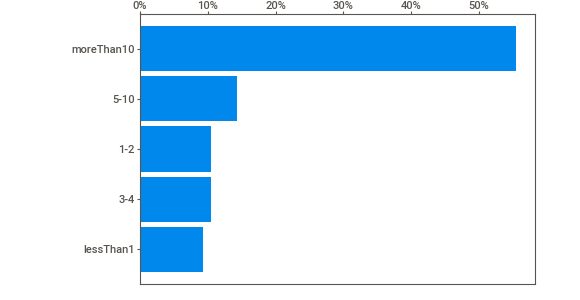
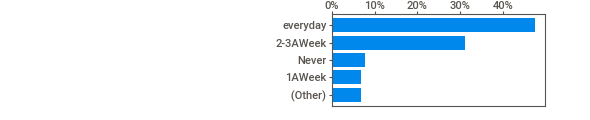
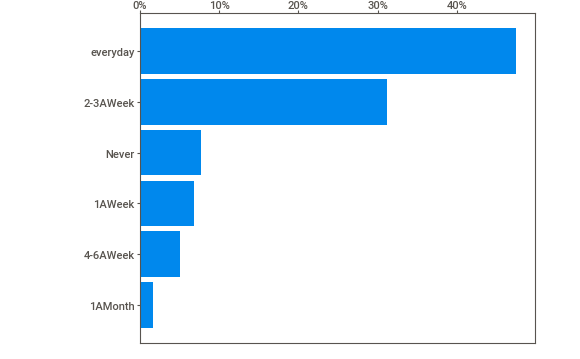
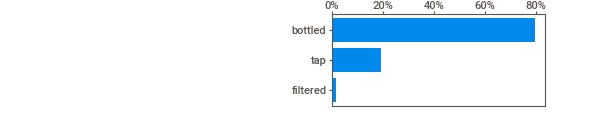
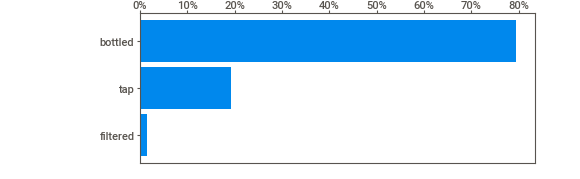
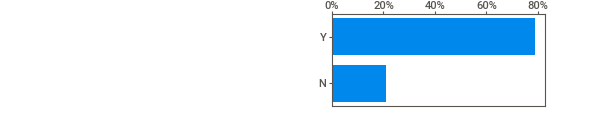
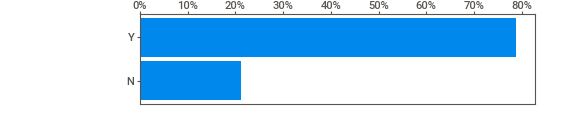
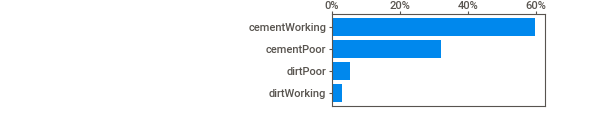
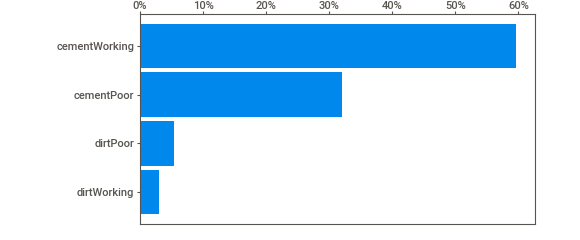
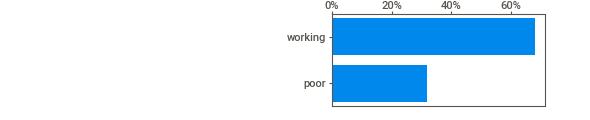
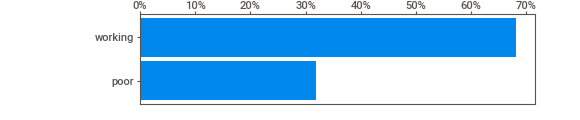
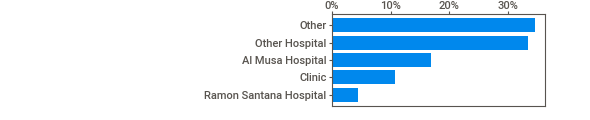
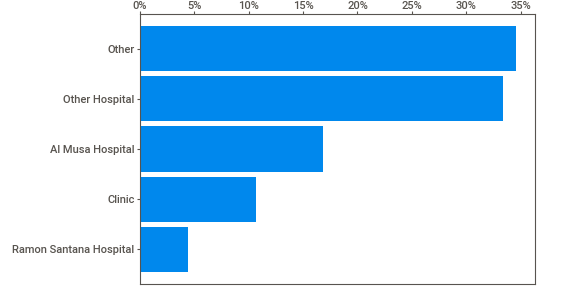
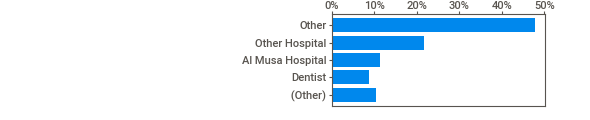
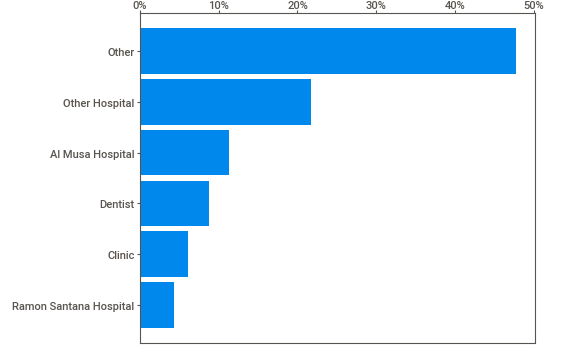
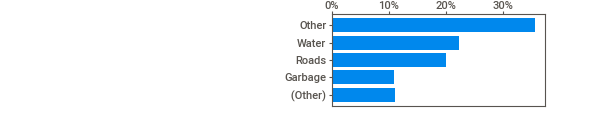
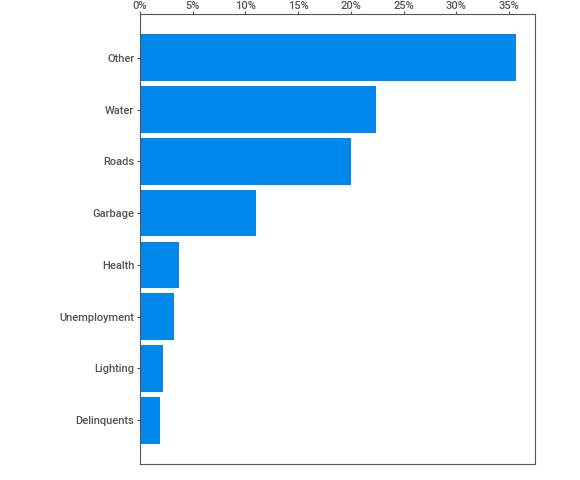
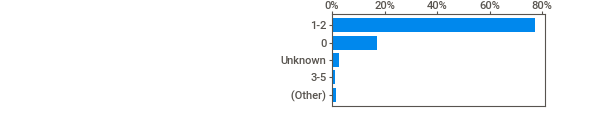
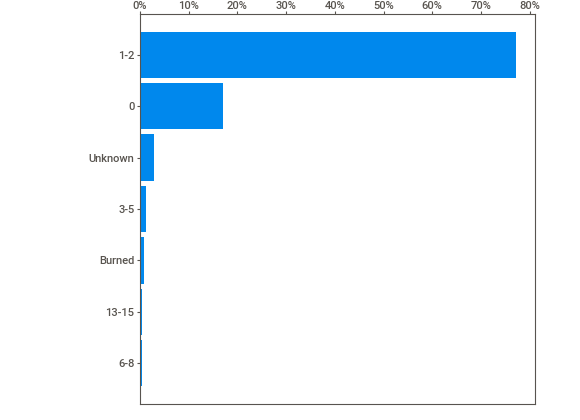
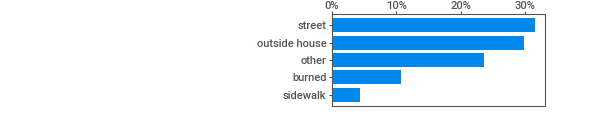
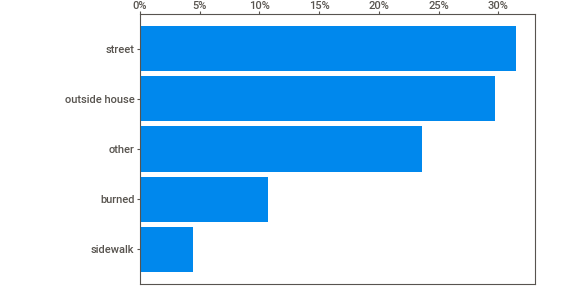
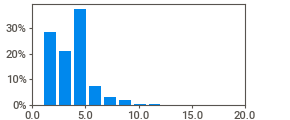
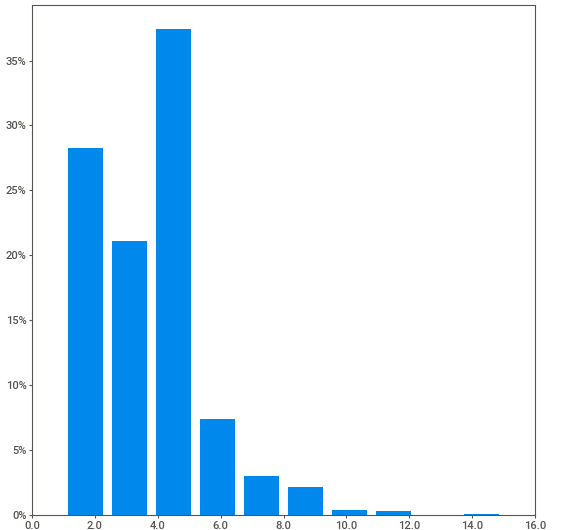
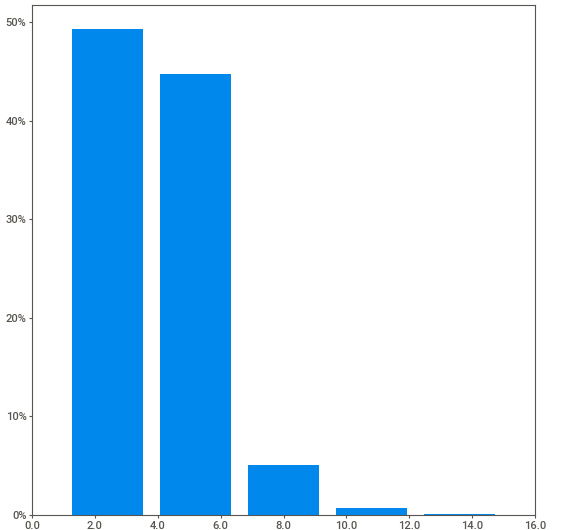
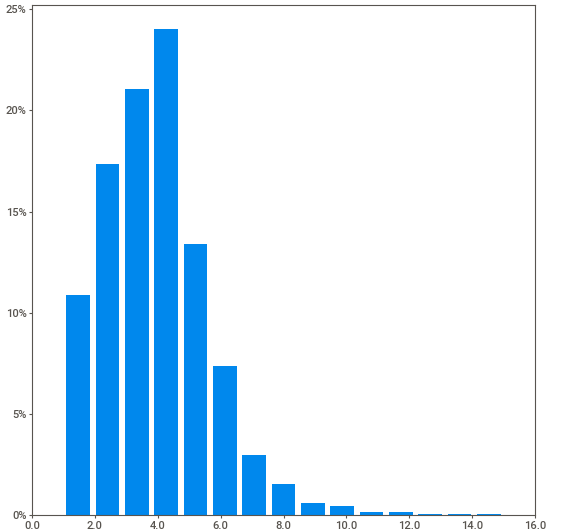
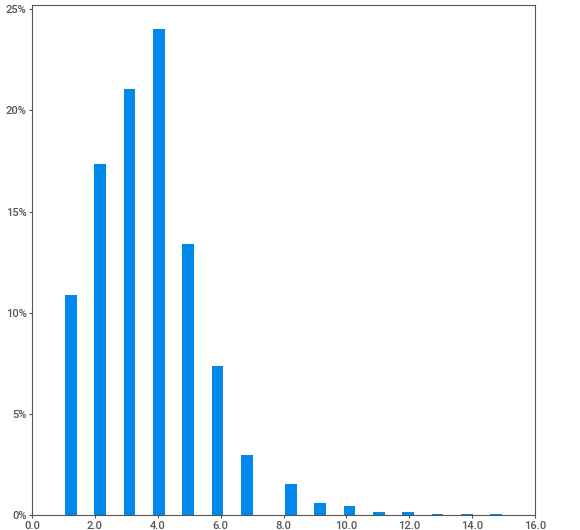
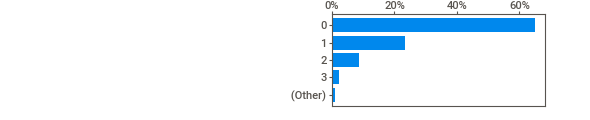
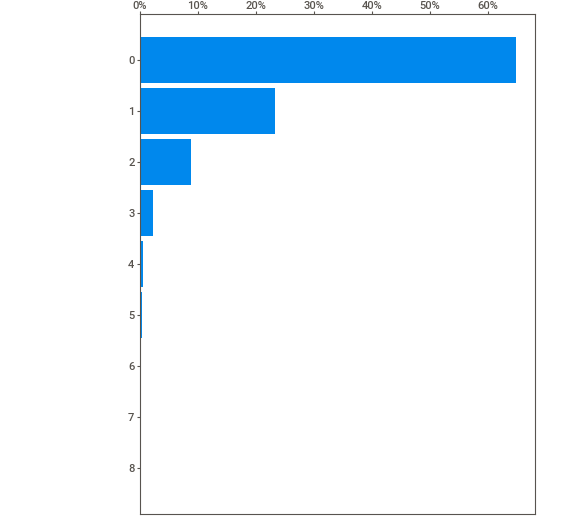
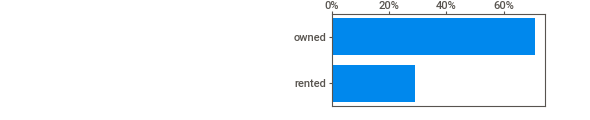
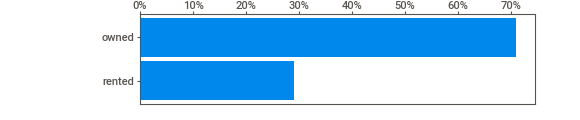
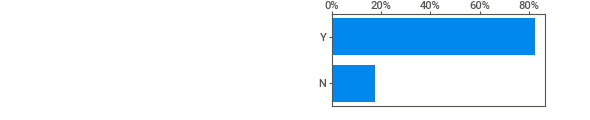
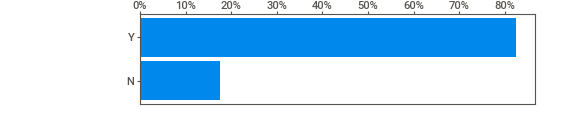
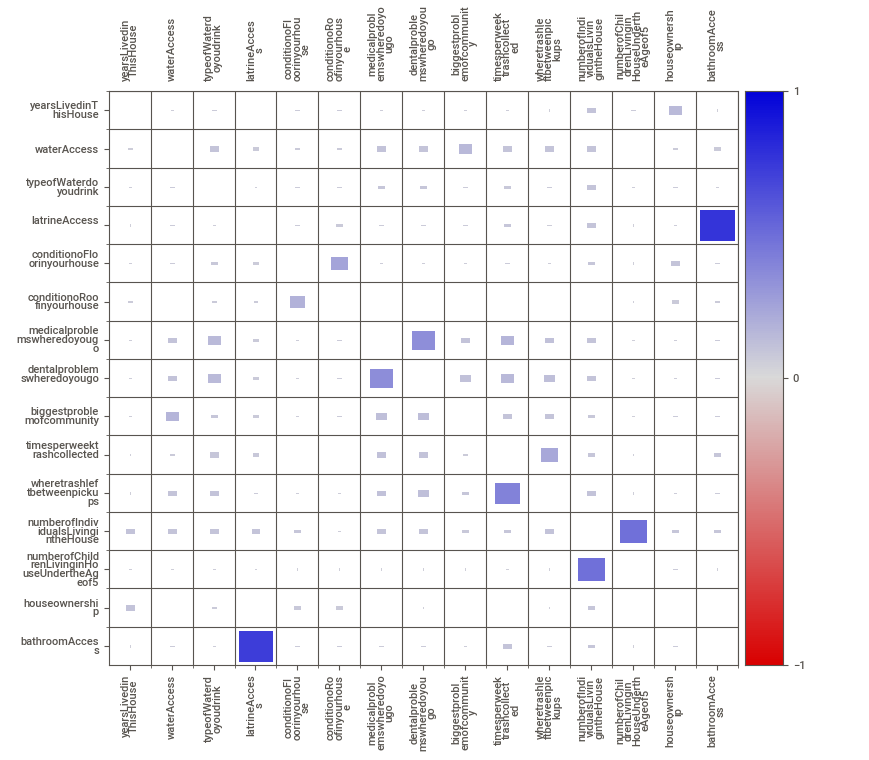
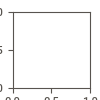

In [35]:
sv_report_history_env = sv.analyze([history_env, "History_env"])
sv_report_history_env.show_notebook()

# Mergings

### 1. History_env x survey_vitals

In [36]:
survey_environ = survey_vitals.merge(history_env, how = "inner", on = "objectId")
survey_environ.head()

,objectId,marriageStatus,occupation,educationLevel,latitude,longitude,age,sex,clustersByLoc,province,...,conditionoRoofinyourhouse,medicalproblemswheredoyougo,dentalproblemswheredoyougo,biggestproblemofcommunity,timesperweektrashcollected,wheretrashleftbetweenpickups,numberofIndividualsLivingintheHouse,numberofChildrenLivinginHouseUndertheAgeof5,houseownership,bathroomAccess
0,lLkC5HGPOC,widow,Ama de casa,lessThanprimary,18.914416,-70.745642,67.0,female,1,San Pedro de Macoris,...,working,Other Hospital,Other Hospital,Roads,1-2,other,1,0,rented,NaN
1,gIoG2SAL99,widow,Other,lessThanprimary,18.914196,-70.746286,80.0,male,1,San Pedro de Macoris,...,poor,Other Hospital,Dentist,Roads,1-2,other,5,0,owned,NaN
2,GiArohoFUo,married,Other,college,18.910474,-70.747658,41.0,female,1,San Pedro de Macoris,...,NaN,Other,Clinic,Other,3-5,other,4,0,NaN,NaN
3,rnNw8AxEix,single,Ama de casa,primary,18.910484,-70.747650,40.0,female,1,San Pedro de Macoris,...,working,Other Hospital,Other,Water,1-2,other,4,0,NaN,NaN
4,YBLTPHNqsH,concubine,Other,lessThanprimary,18.915163,-70.741626,59.0,male,1,San Pedro de Macoris,...,working,Clinic,Other,Other,1-2,street,4,0,NaN,NaN


ConversionError: Failed to convert value(s) to axis units: 0       2-3AWeek
1         1AWeek
2       2-3AWeek
3       4-6AWeek
4       2-3AWeek
          ...   
5418       Never
5419       Never
5420       Never
5421       Never
5422       Never
Name: x, Length: 5423, dtype: object

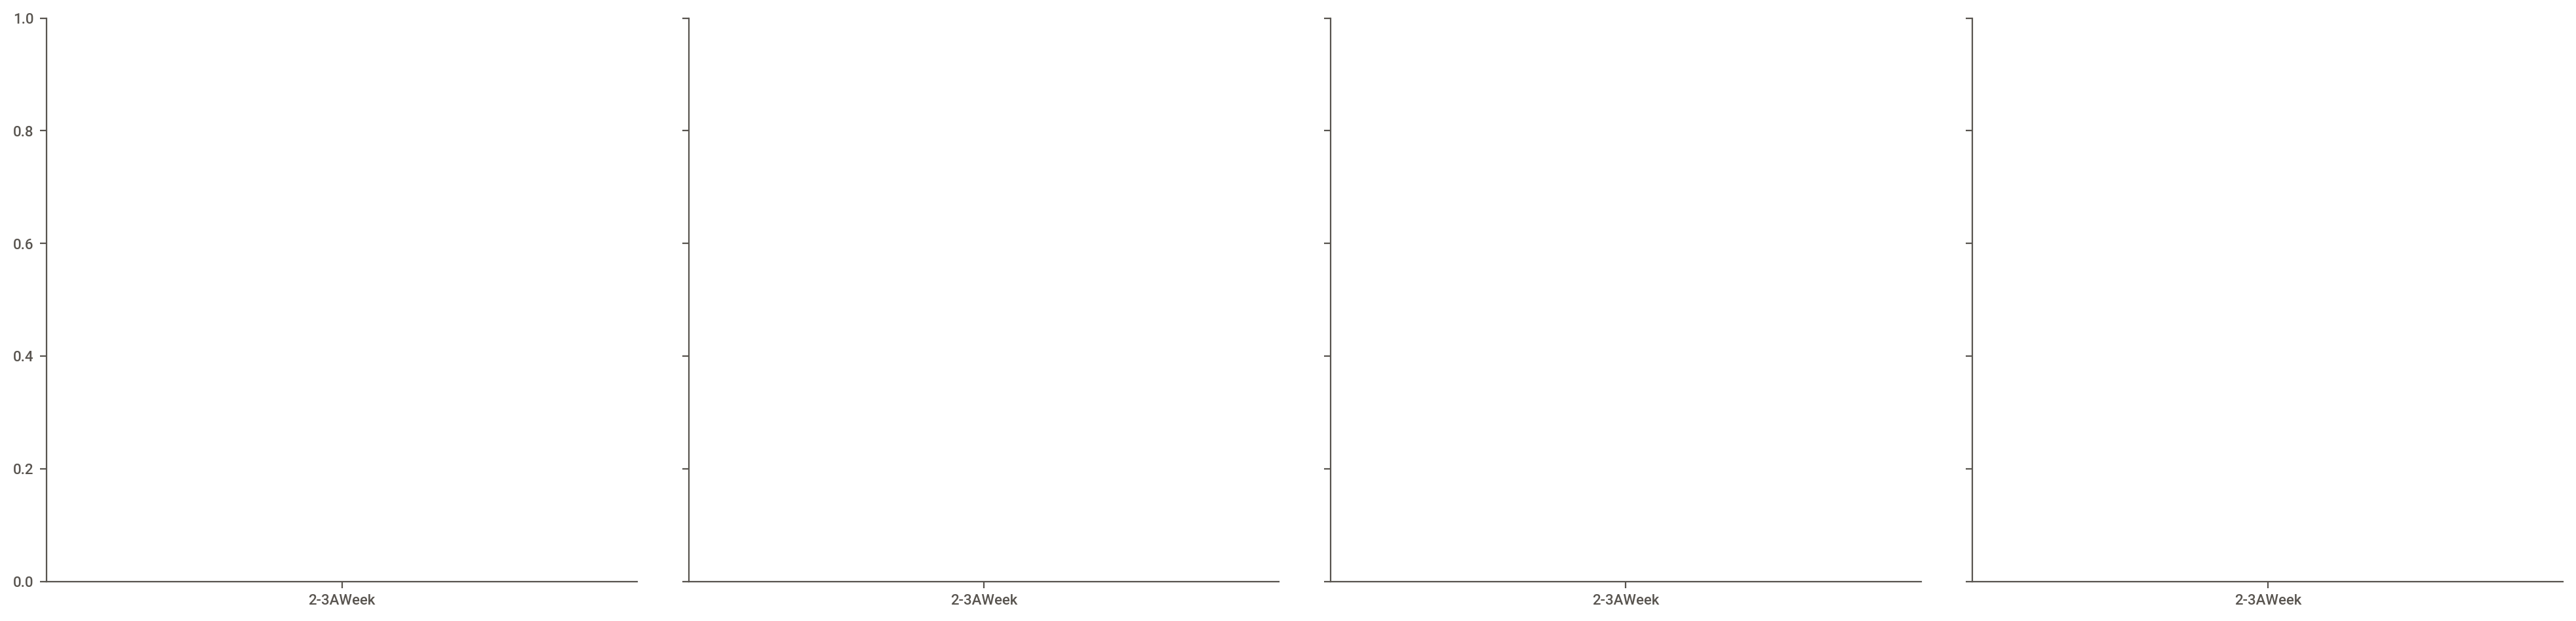

In [37]:
sns.displot(survey_environ, x="waterAccess", col="province", hue = "waterAccess", multiple="dodge")

In [38]:
survey_environ.shape

(5423, 25)

In [39]:
survey_environ.isna().sum()

objectId                                          0
marriageStatus                                    0
occupation                                        0
educationLevel                                  206
latitude                                          0
longitude                                         0
age                                               0
sex                                               0
clustersByLoc                                     0
province                                          0
yearsLivedinThisHouse                            17
waterAccess                                      84
typeofWaterdoyoudrink                            40
latrineAccess                                  2208
conditionoFloorinyourhouse                       98
conditionoRoofinyourhouse                       119
medicalproblemswheredoyougo                       0
dentalproblemswheredoyougo                        0
biggestproblemofcommunity                         0
timesperweek

In [40]:
survey_environ.province.value_counts()

San Pedro de Macoris          2623
Lavega                        2555
Santiago                       211
San Pedro de Macoris/North      34
Name: province, dtype: int64

In [41]:
province_waterAccess_percent = pd.crosstab(index = survey_environ["waterAccess"], columns = survey_environ["province"])#.apply(lambda r: r/r.sum(), axis=0)
province_waterAccess_percent

province,Lavega,San Pedro de Macoris,San Pedro de Macoris/North,Santiago
waterAccess,,,,
1AMonth,21,66,0,1
1AWeek,51,314,0,3
2-3AWeek,594,1062,1,16
4-6AWeek,55,202,7,2
Never,114,128,3,168
everyday,1702,788,21,20


In [42]:
def by_province(df, feature):
    res_df = pd.crosstab(index = df[feature], columns = df["province"]).reset_index()
    
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
    fig.set_size_inches(20,20)
    ax1 = sns.barplot(x = feature, y = "Lavega", data = res_df, ax = ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, horizontalalignment='right')
    ax1.set_title("Distribution of " + feature + " Types in Lavega")
    ax1.set_ylabel("Count")
    
    ax2 = sns.barplot(x = feature, y = "Santiago", data = res_df, ax = ax2)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=15, horizontalalignment='right')
    ax2.set_title("Distribution of " + feature + " Types in Santiago")    
    ax2.set_ylabel("Count")
    
    ax3 = sns.barplot(x = feature, y = "San Pedro de Macoris", data = res_df, ax = ax3)
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=15, horizontalalignment='right')
    ax3.set_title("Distribution of " + feature + " Types in San Pedro de Macoris")      
    ax3.set_ylabel("Count")
    
    ax4 = sns.barplot(x = feature, y = "San Pedro de Macoris/North", data = res_df, ax = ax4)
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=15, horizontalalignment='right')
    ax4.set_title("Distribution of " + feature + " Types in San Pedro de Macoris/North")
    ax4.set_ylabel("Count")

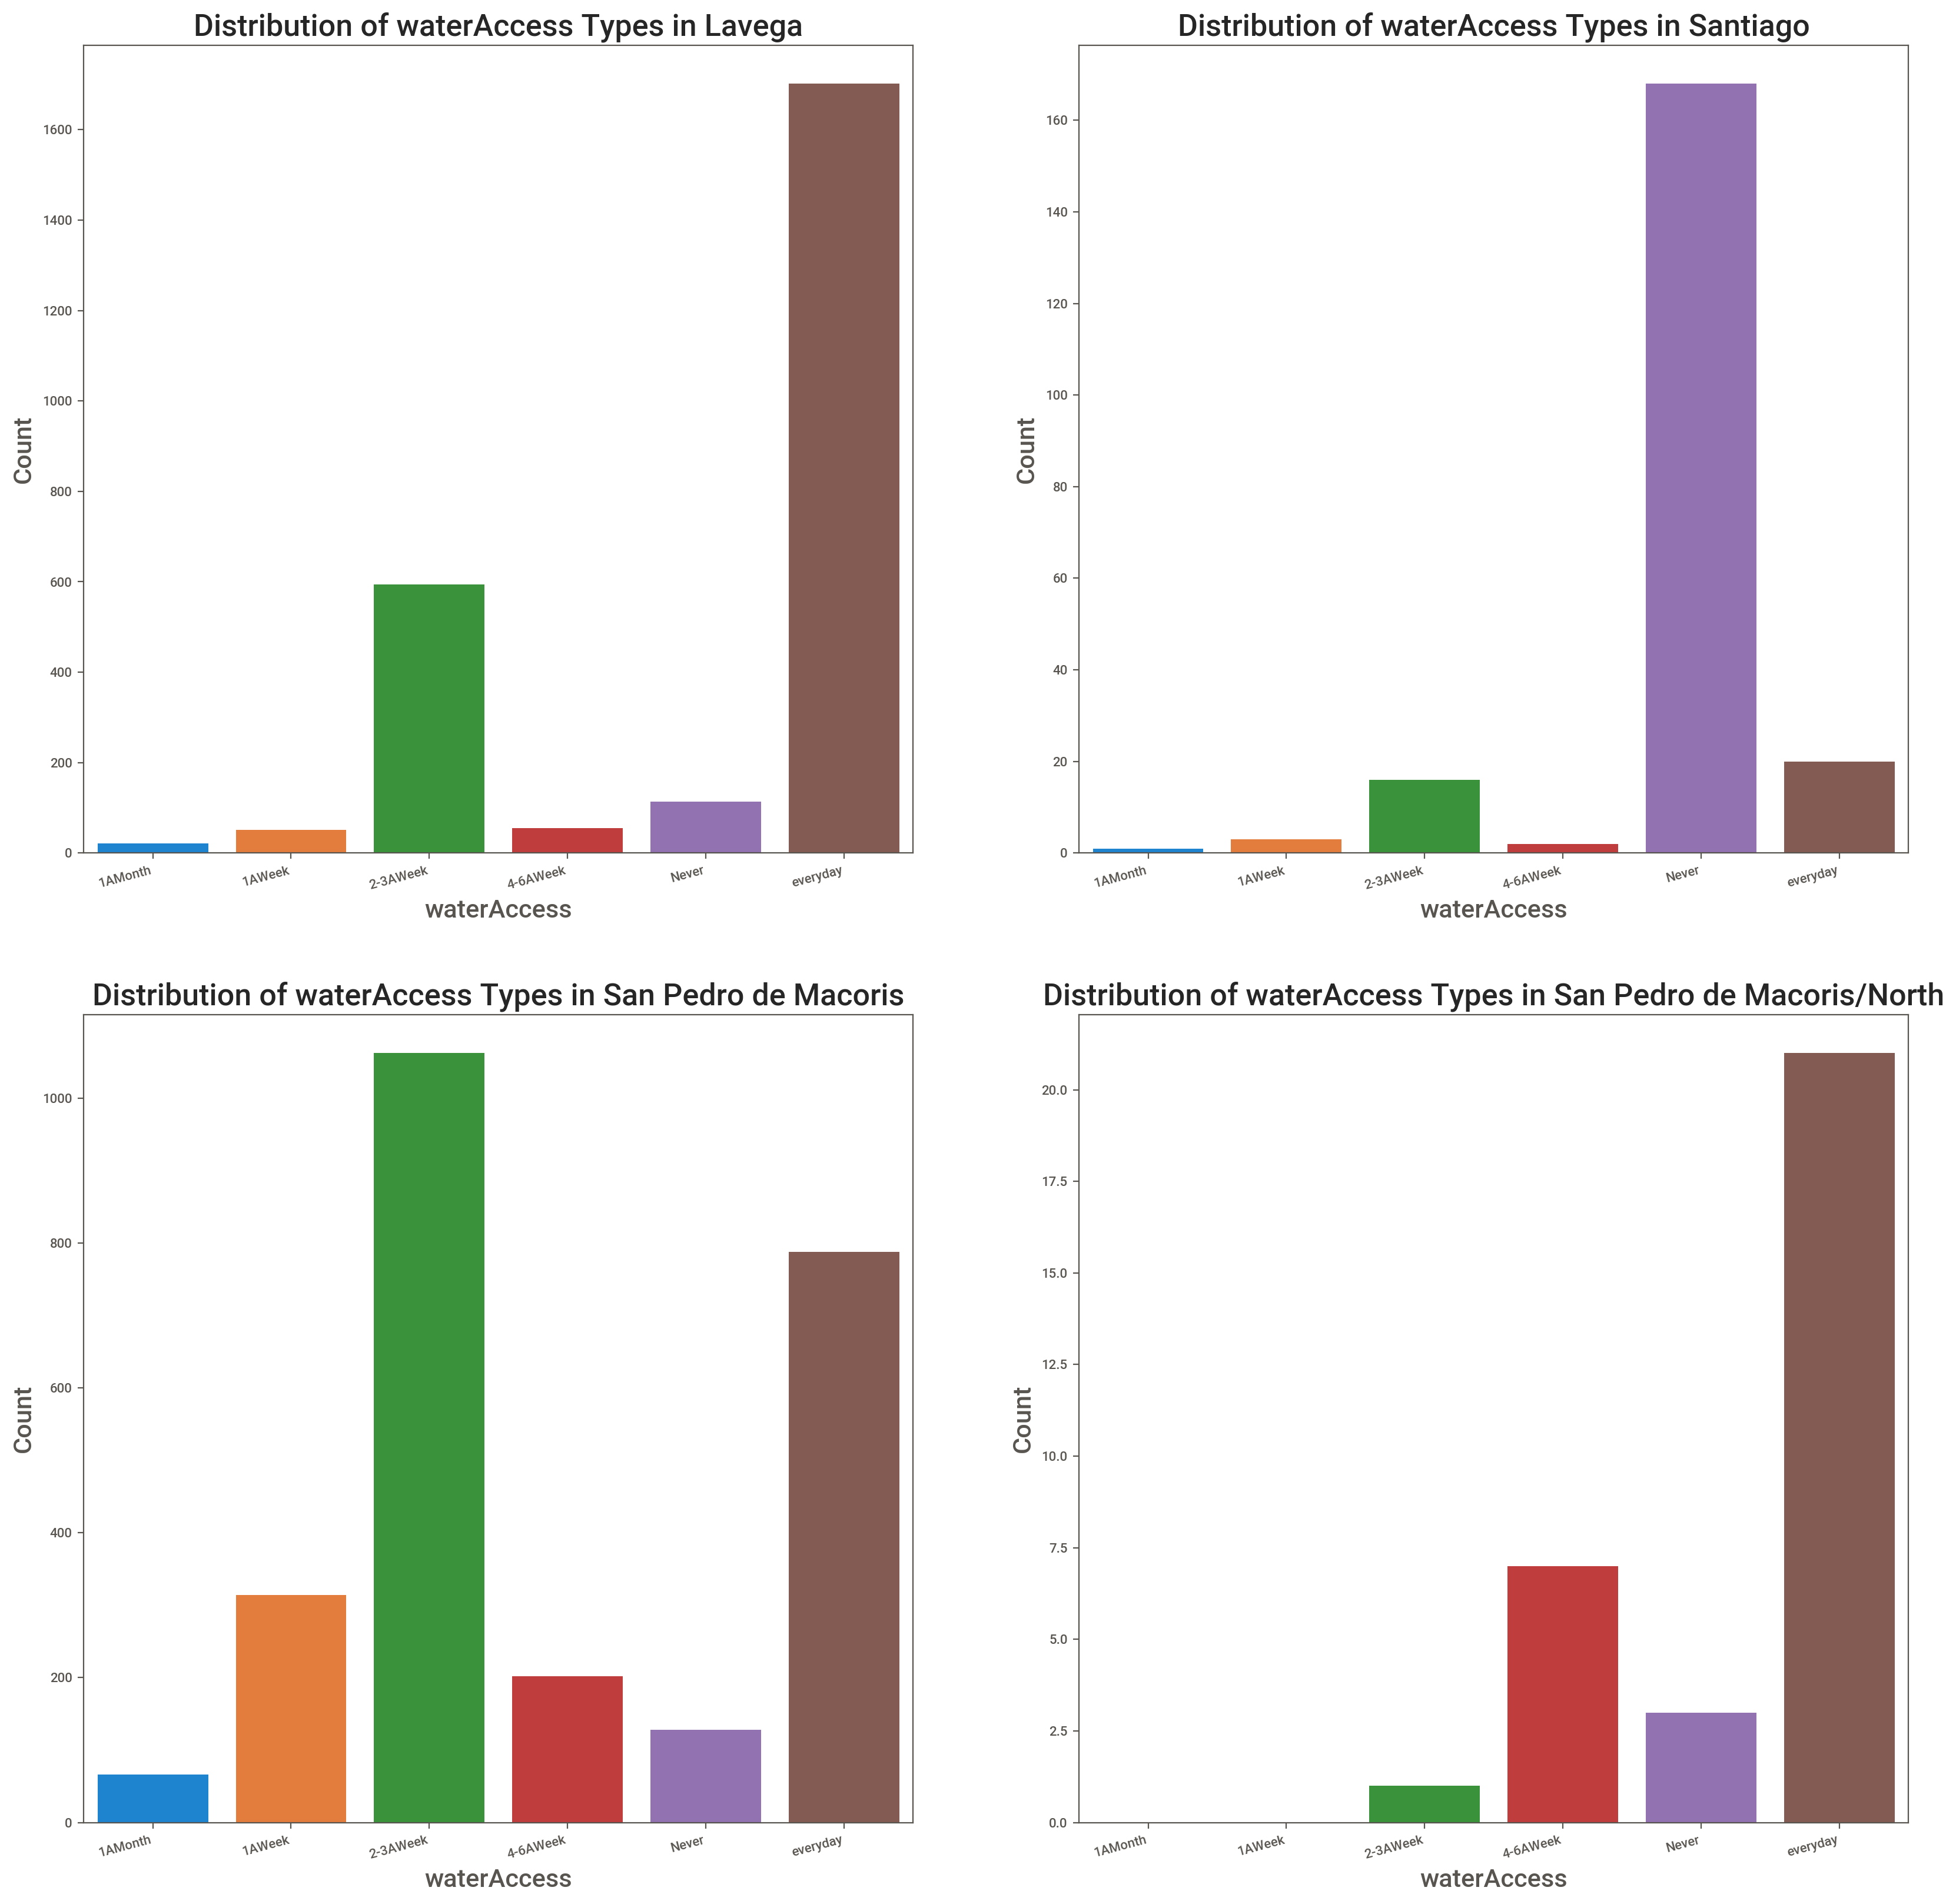

In [43]:
by_province(survey_environ, "waterAccess")

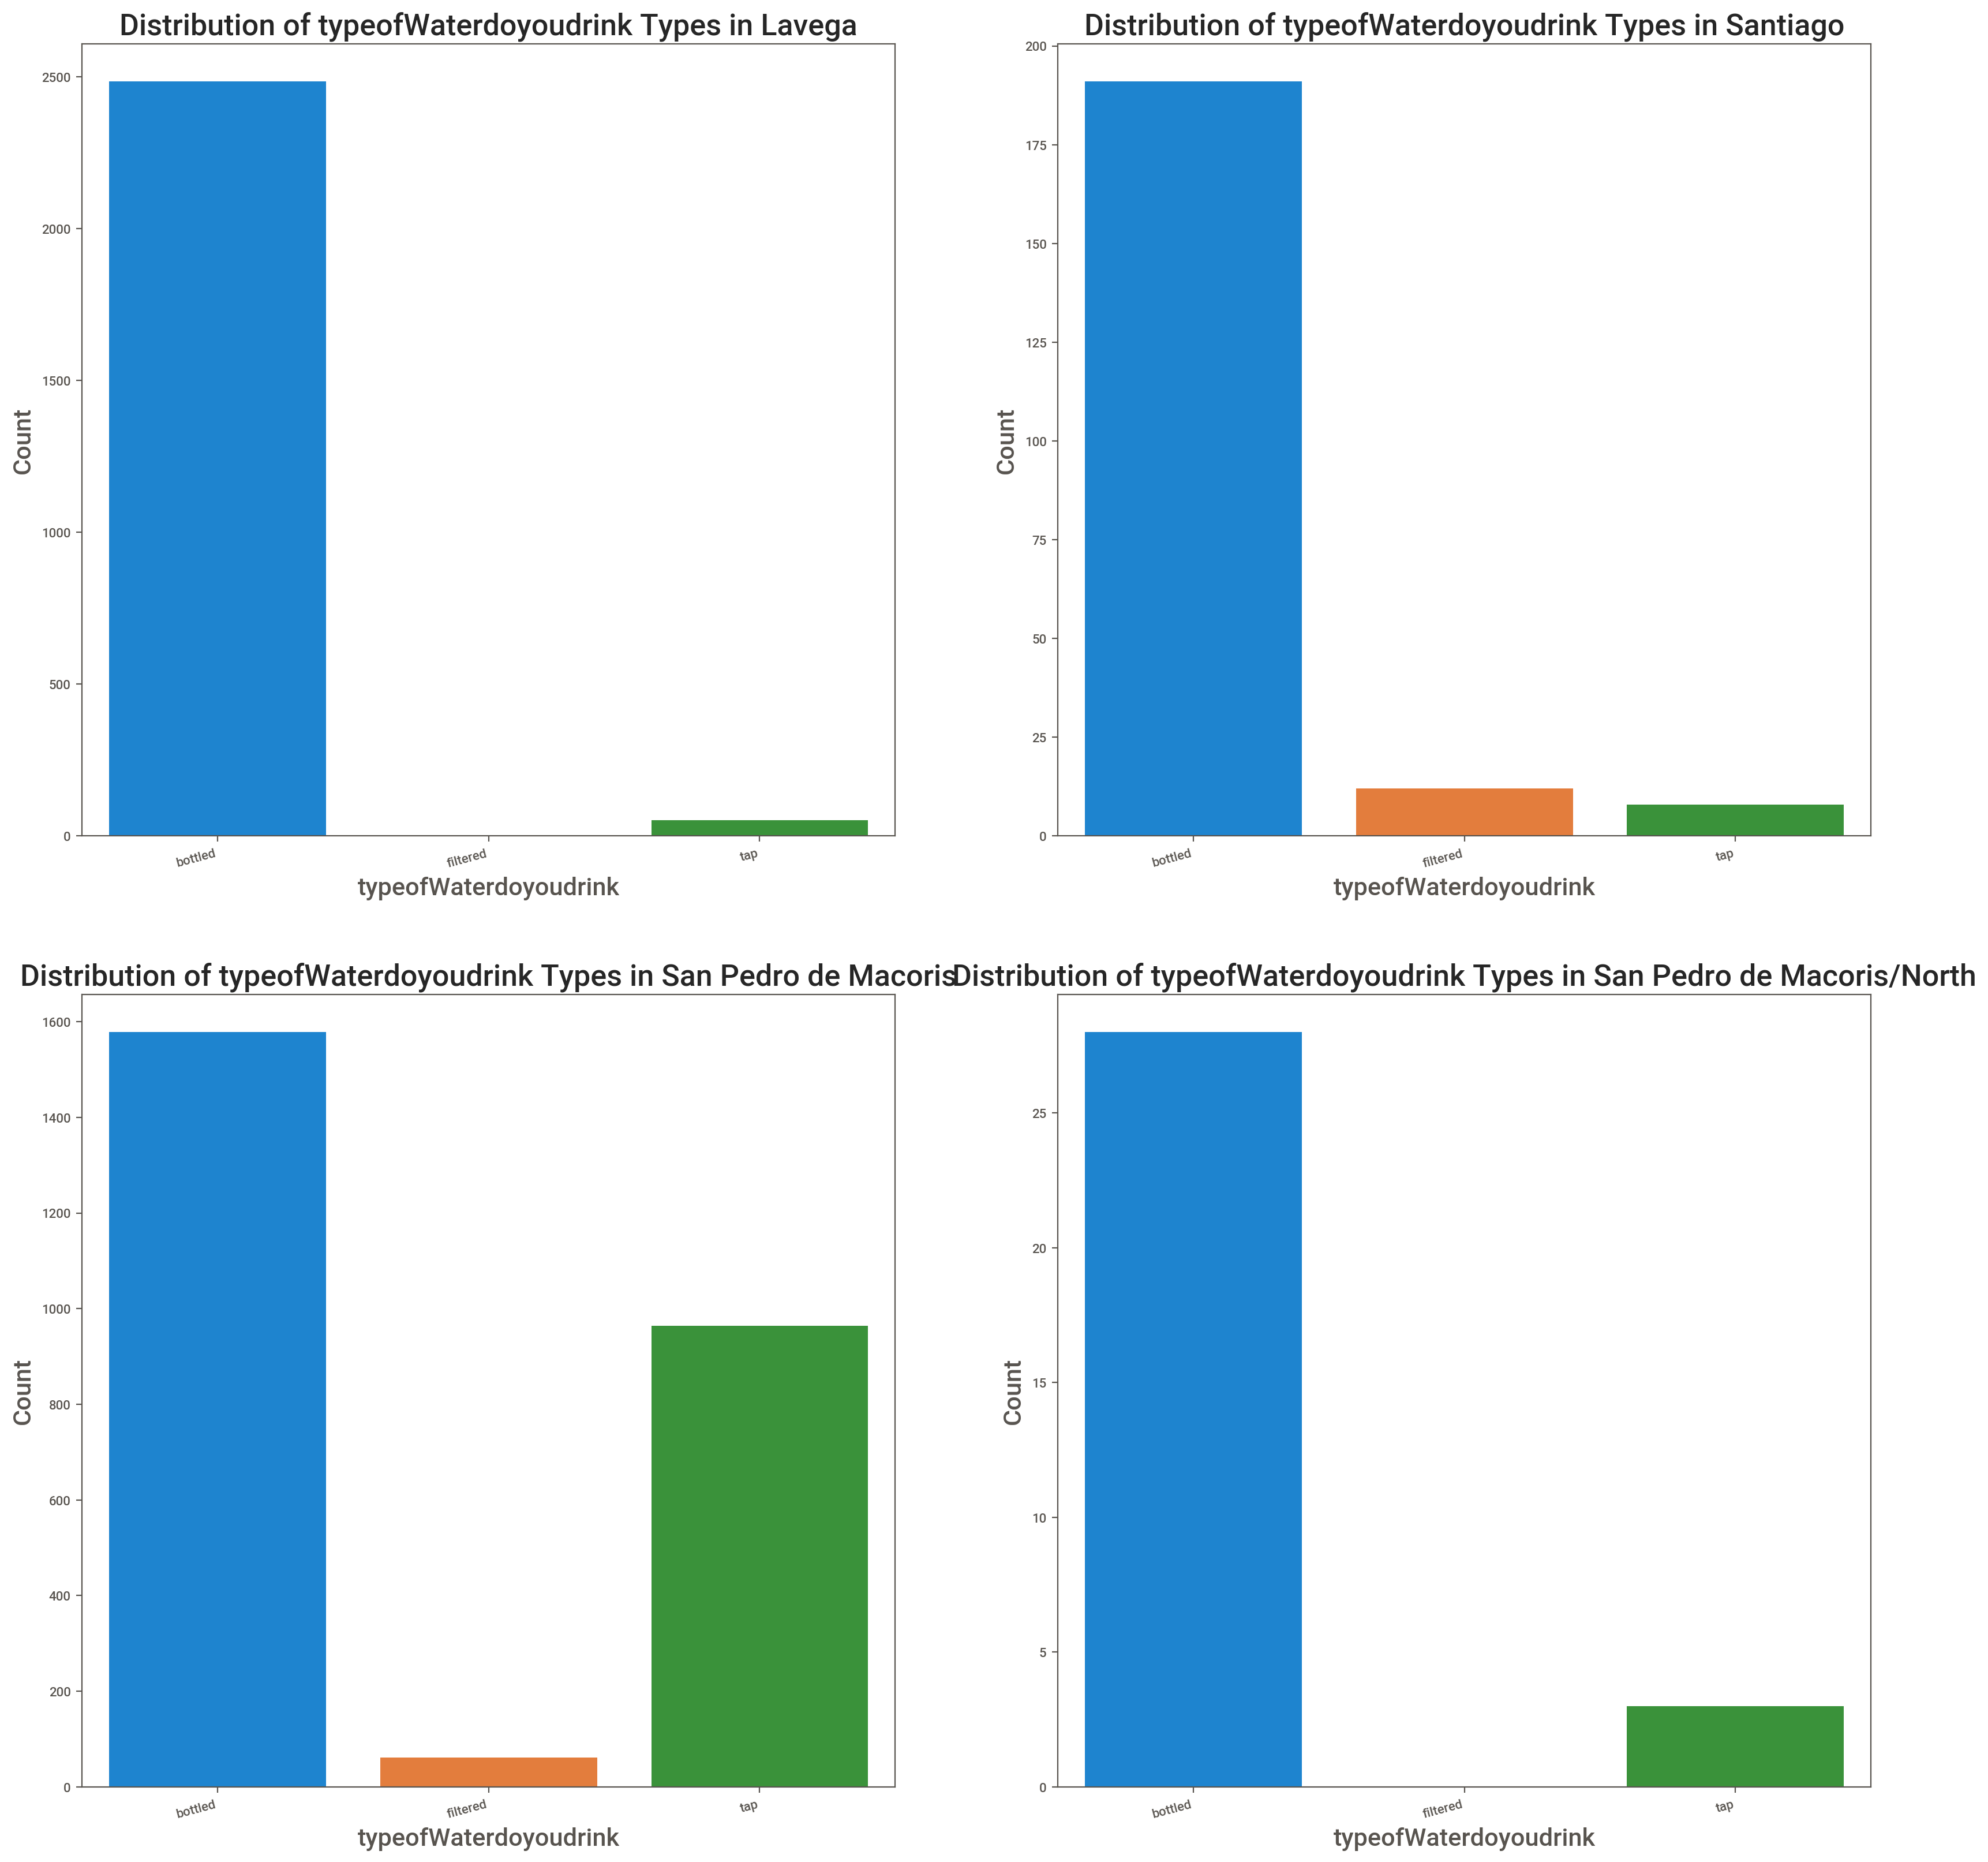

In [44]:
by_province(survey_environ, "typeofWaterdoyoudrink")

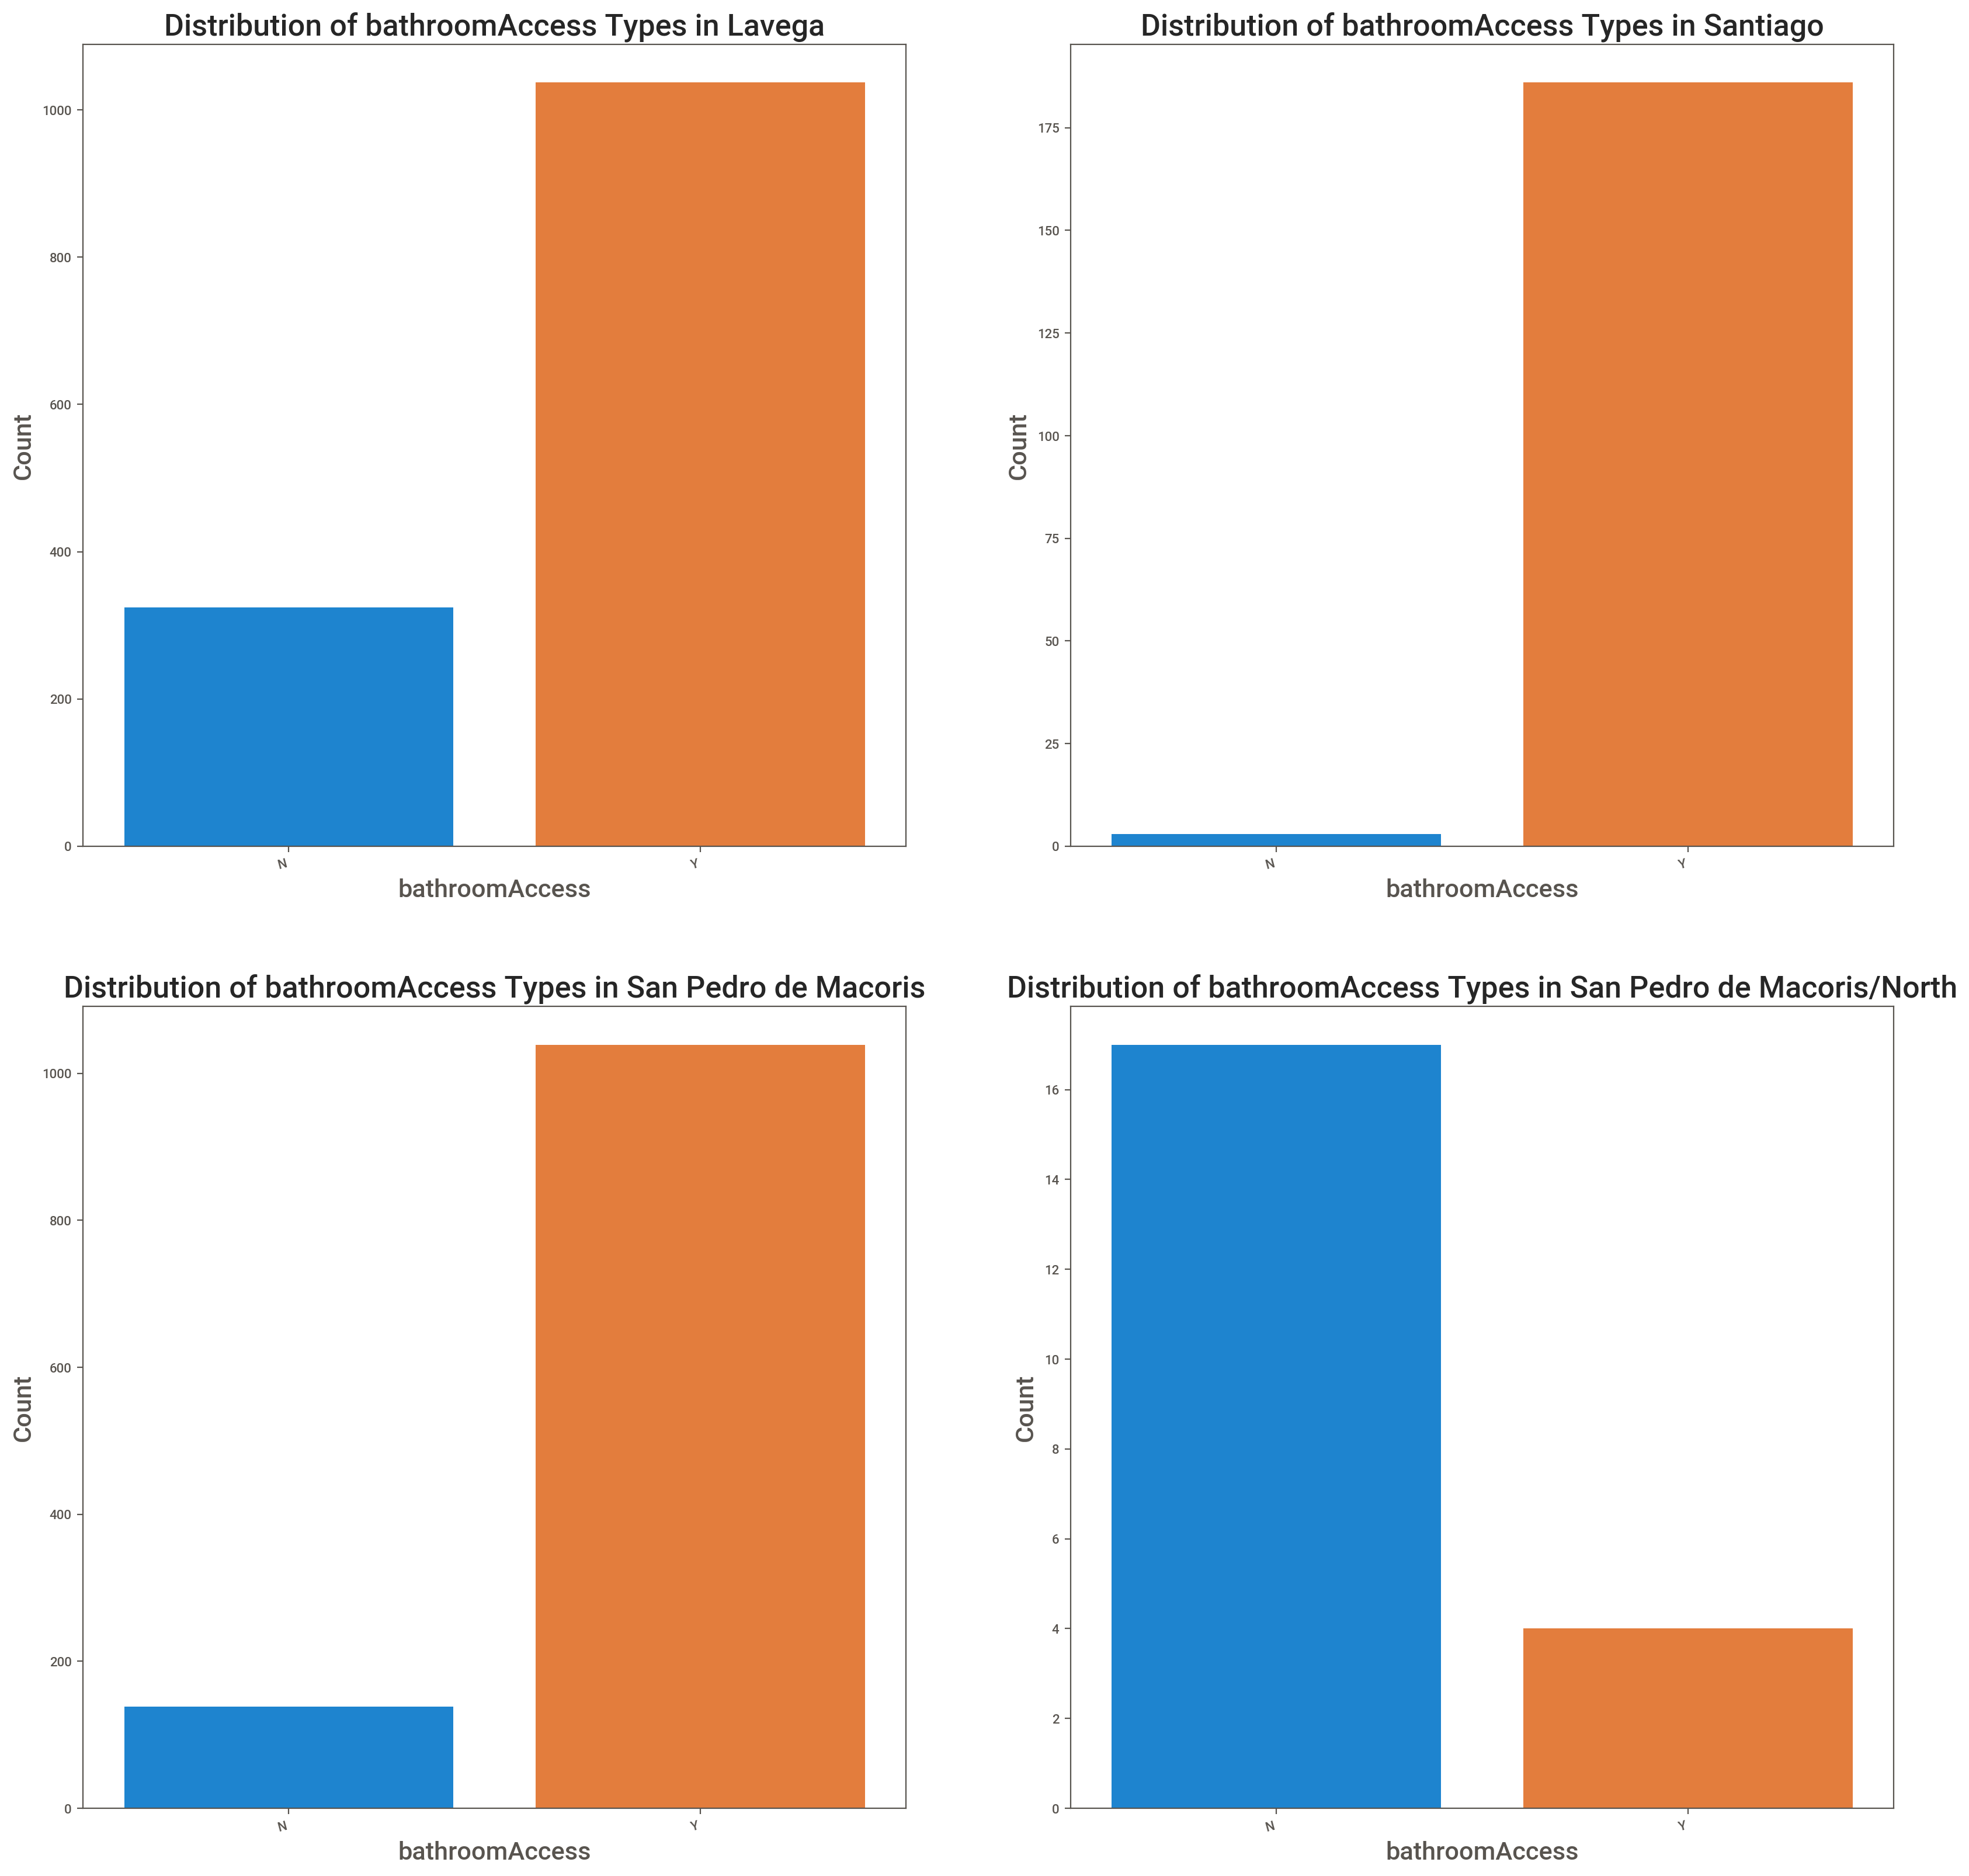

In [45]:
by_province(survey_environ, "bathroomAccess")

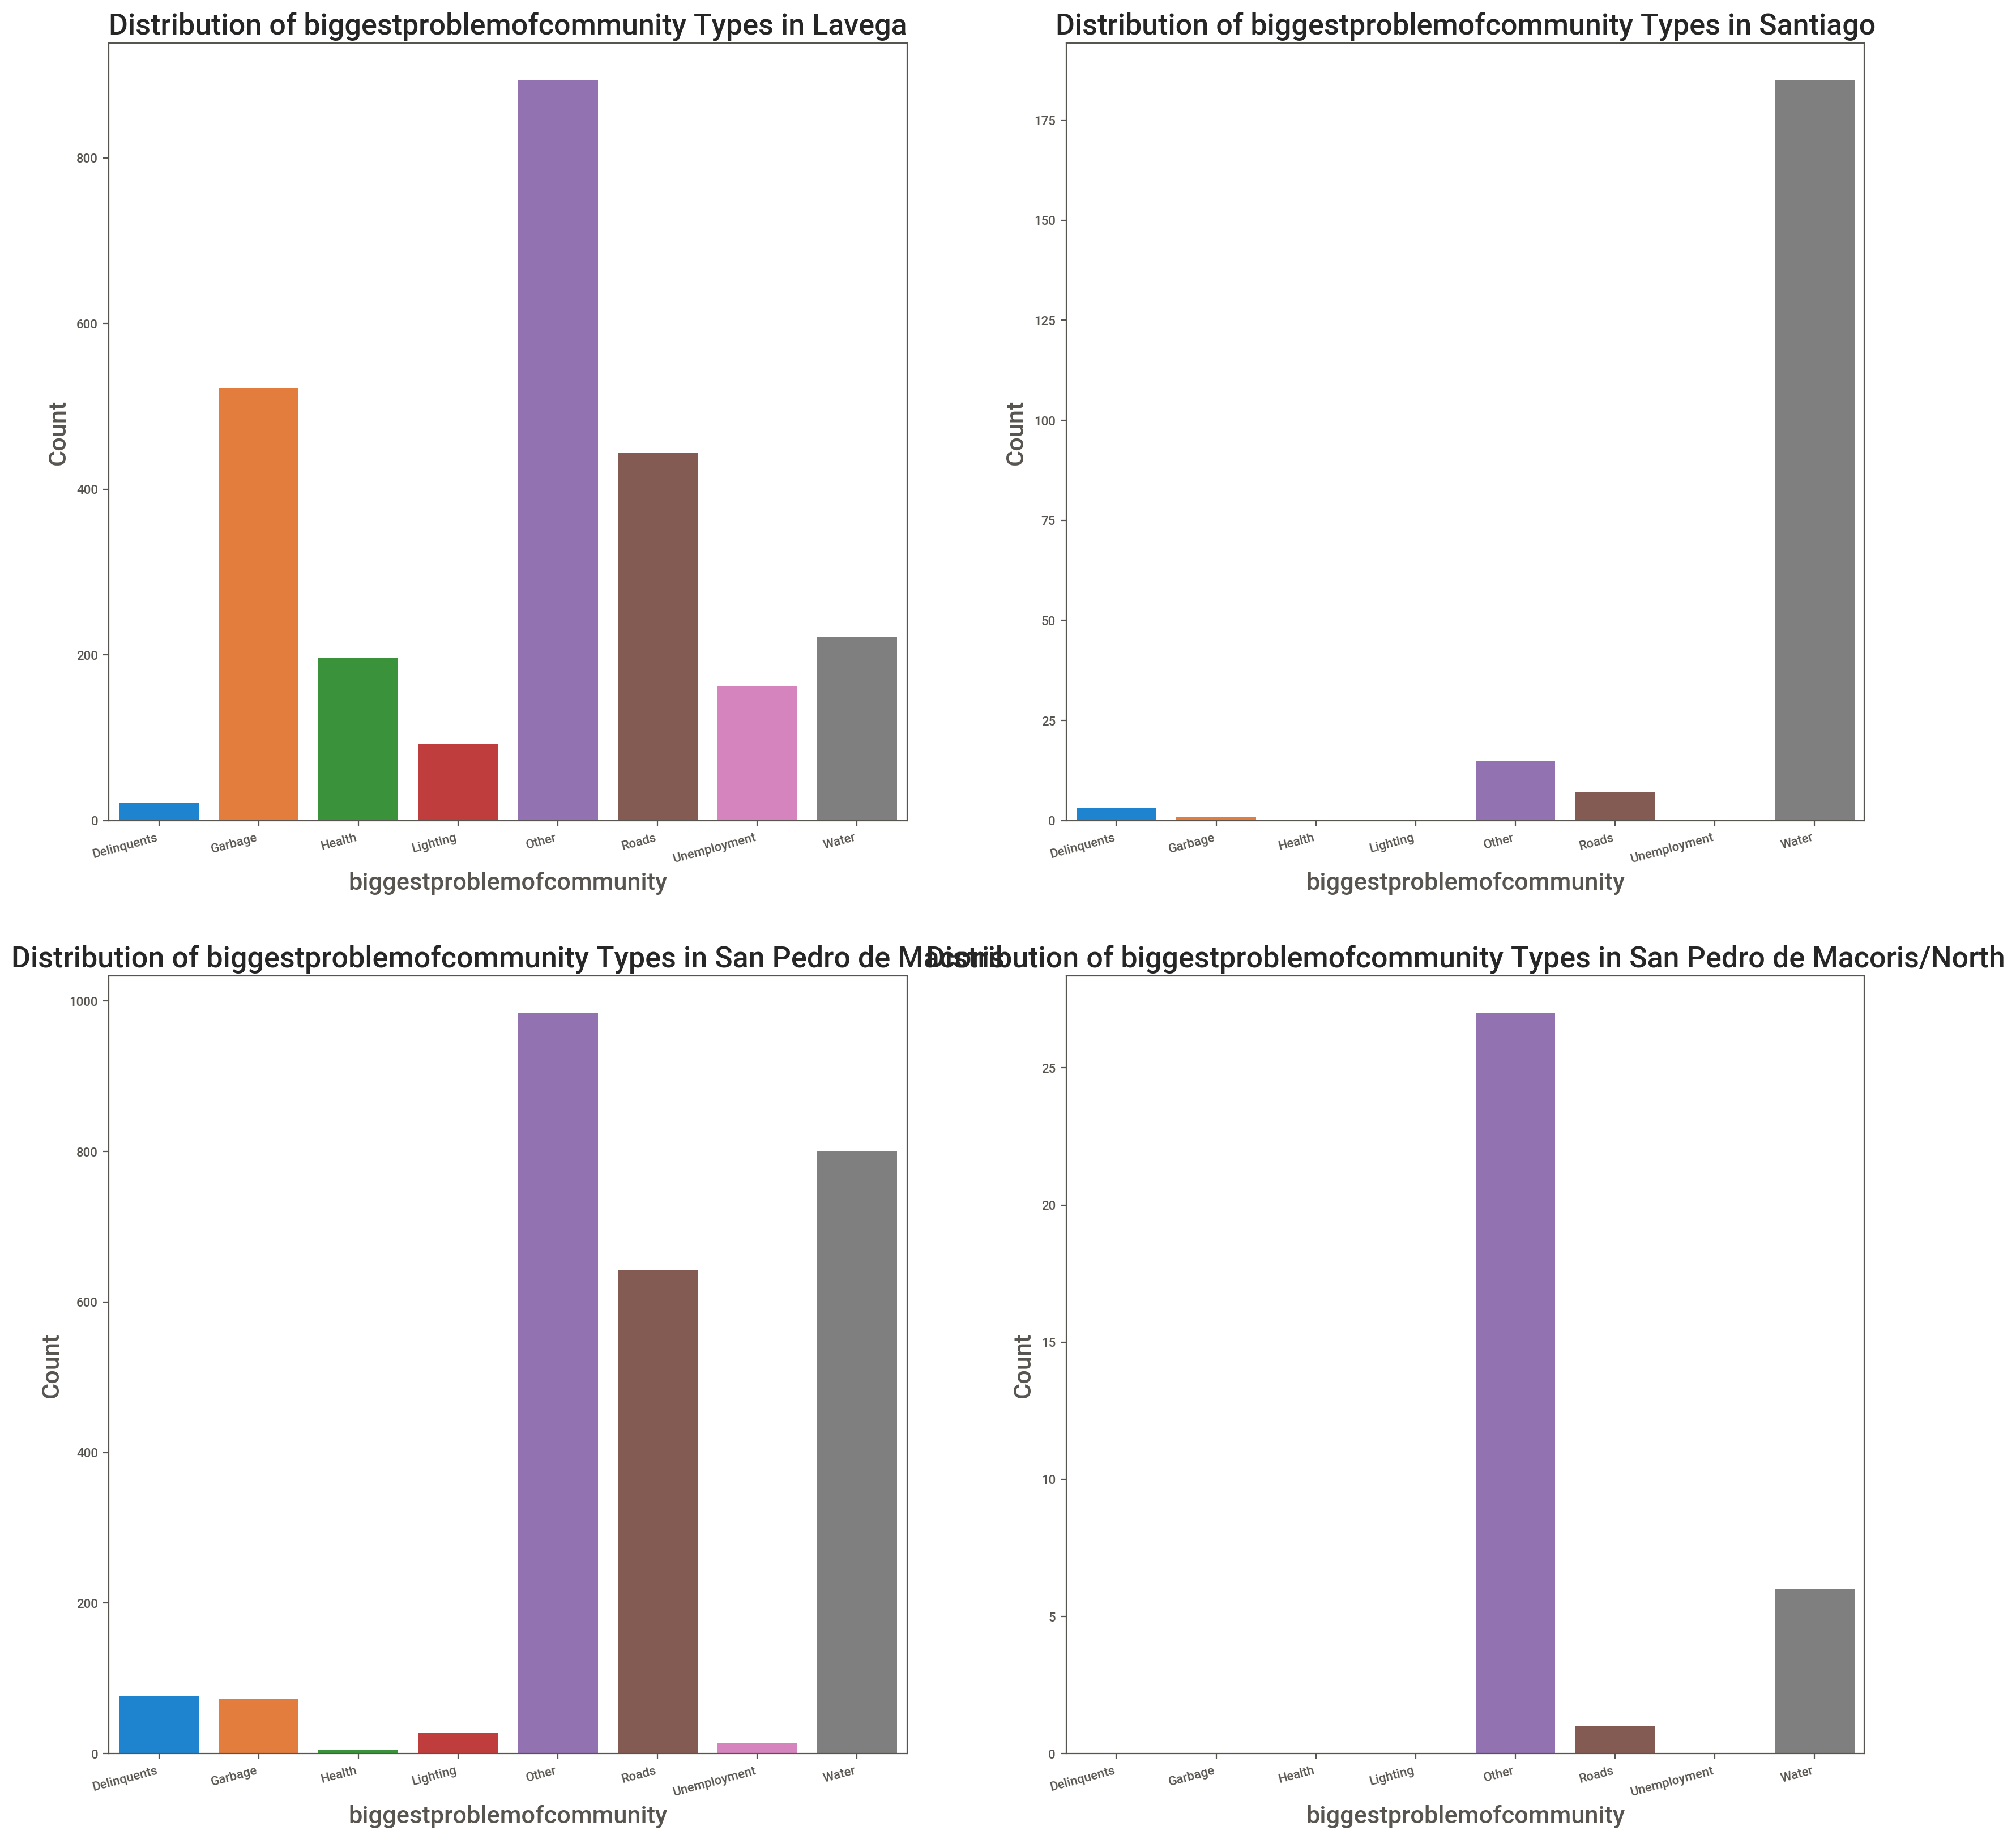

In [46]:
by_province(survey_environ, "biggestproblemofcommunity")

### 2. Survey_vitals x eval_med

In [47]:
survey_med = survey_vitals.merge(eval_med, how = "inner", on = "objectId")
survey_med.head()

,objectId,marriageStatus,occupation,educationLevel,latitude,longitude,age,sex,clustersByLoc,province,AssessmentandEvaluation,planOfAction,duration,part_of_body,trauma_induced,condition_progression
0,8BAdCPGEE1,concubine,Other,lessThanprimary,18.912805,-70.744914,73.0,male,1,San Pedro de Macoris,Yes,none,NaN,NaN,NaN,NaN
1,8BAdCPGEE1,concubine,Other,lessThanprimary,18.912805,-70.744914,73.0,male,1,San Pedro de Macoris,Yes,other,NaN,NaN,NaN,NaN
2,bWCqNwtKYL,concubine,Ama de casa,lessThanprimary,18.912537,-70.744927,65.0,female,1,San Pedro de Macoris,No,none,NaN,NaN,NaN,NaN
3,bWCqNwtKYL,concubine,Ama de casa,lessThanprimary,18.912537,-70.744927,65.0,female,1,San Pedro de Macoris,Yes,other,NaN,NaN,NaN,NaN
4,056xDPGU2U,concubine,Other,lessThanprimary,18.912727,-70.745074,79.0,male,1,San Pedro de Macoris,No,none,NaN,NaN,NaN,NaN


In [48]:
len(survey_med[survey_med["province"] == "La Vega"])

0

In [49]:
survey_med.isna().sum()

objectId                      0
marriageStatus                0
occupation                    0
educationLevel              538
latitude                      0
longitude                     0
age                           0
sex                           0
clustersByLoc                 0
province                      0
AssessmentandEvaluation       0
planOfAction                  0
duration                    645
part_of_body               1439
trauma_induced              746
condition_progression       771
dtype: int64

ValueError: Could not interpret input 'Santiago'

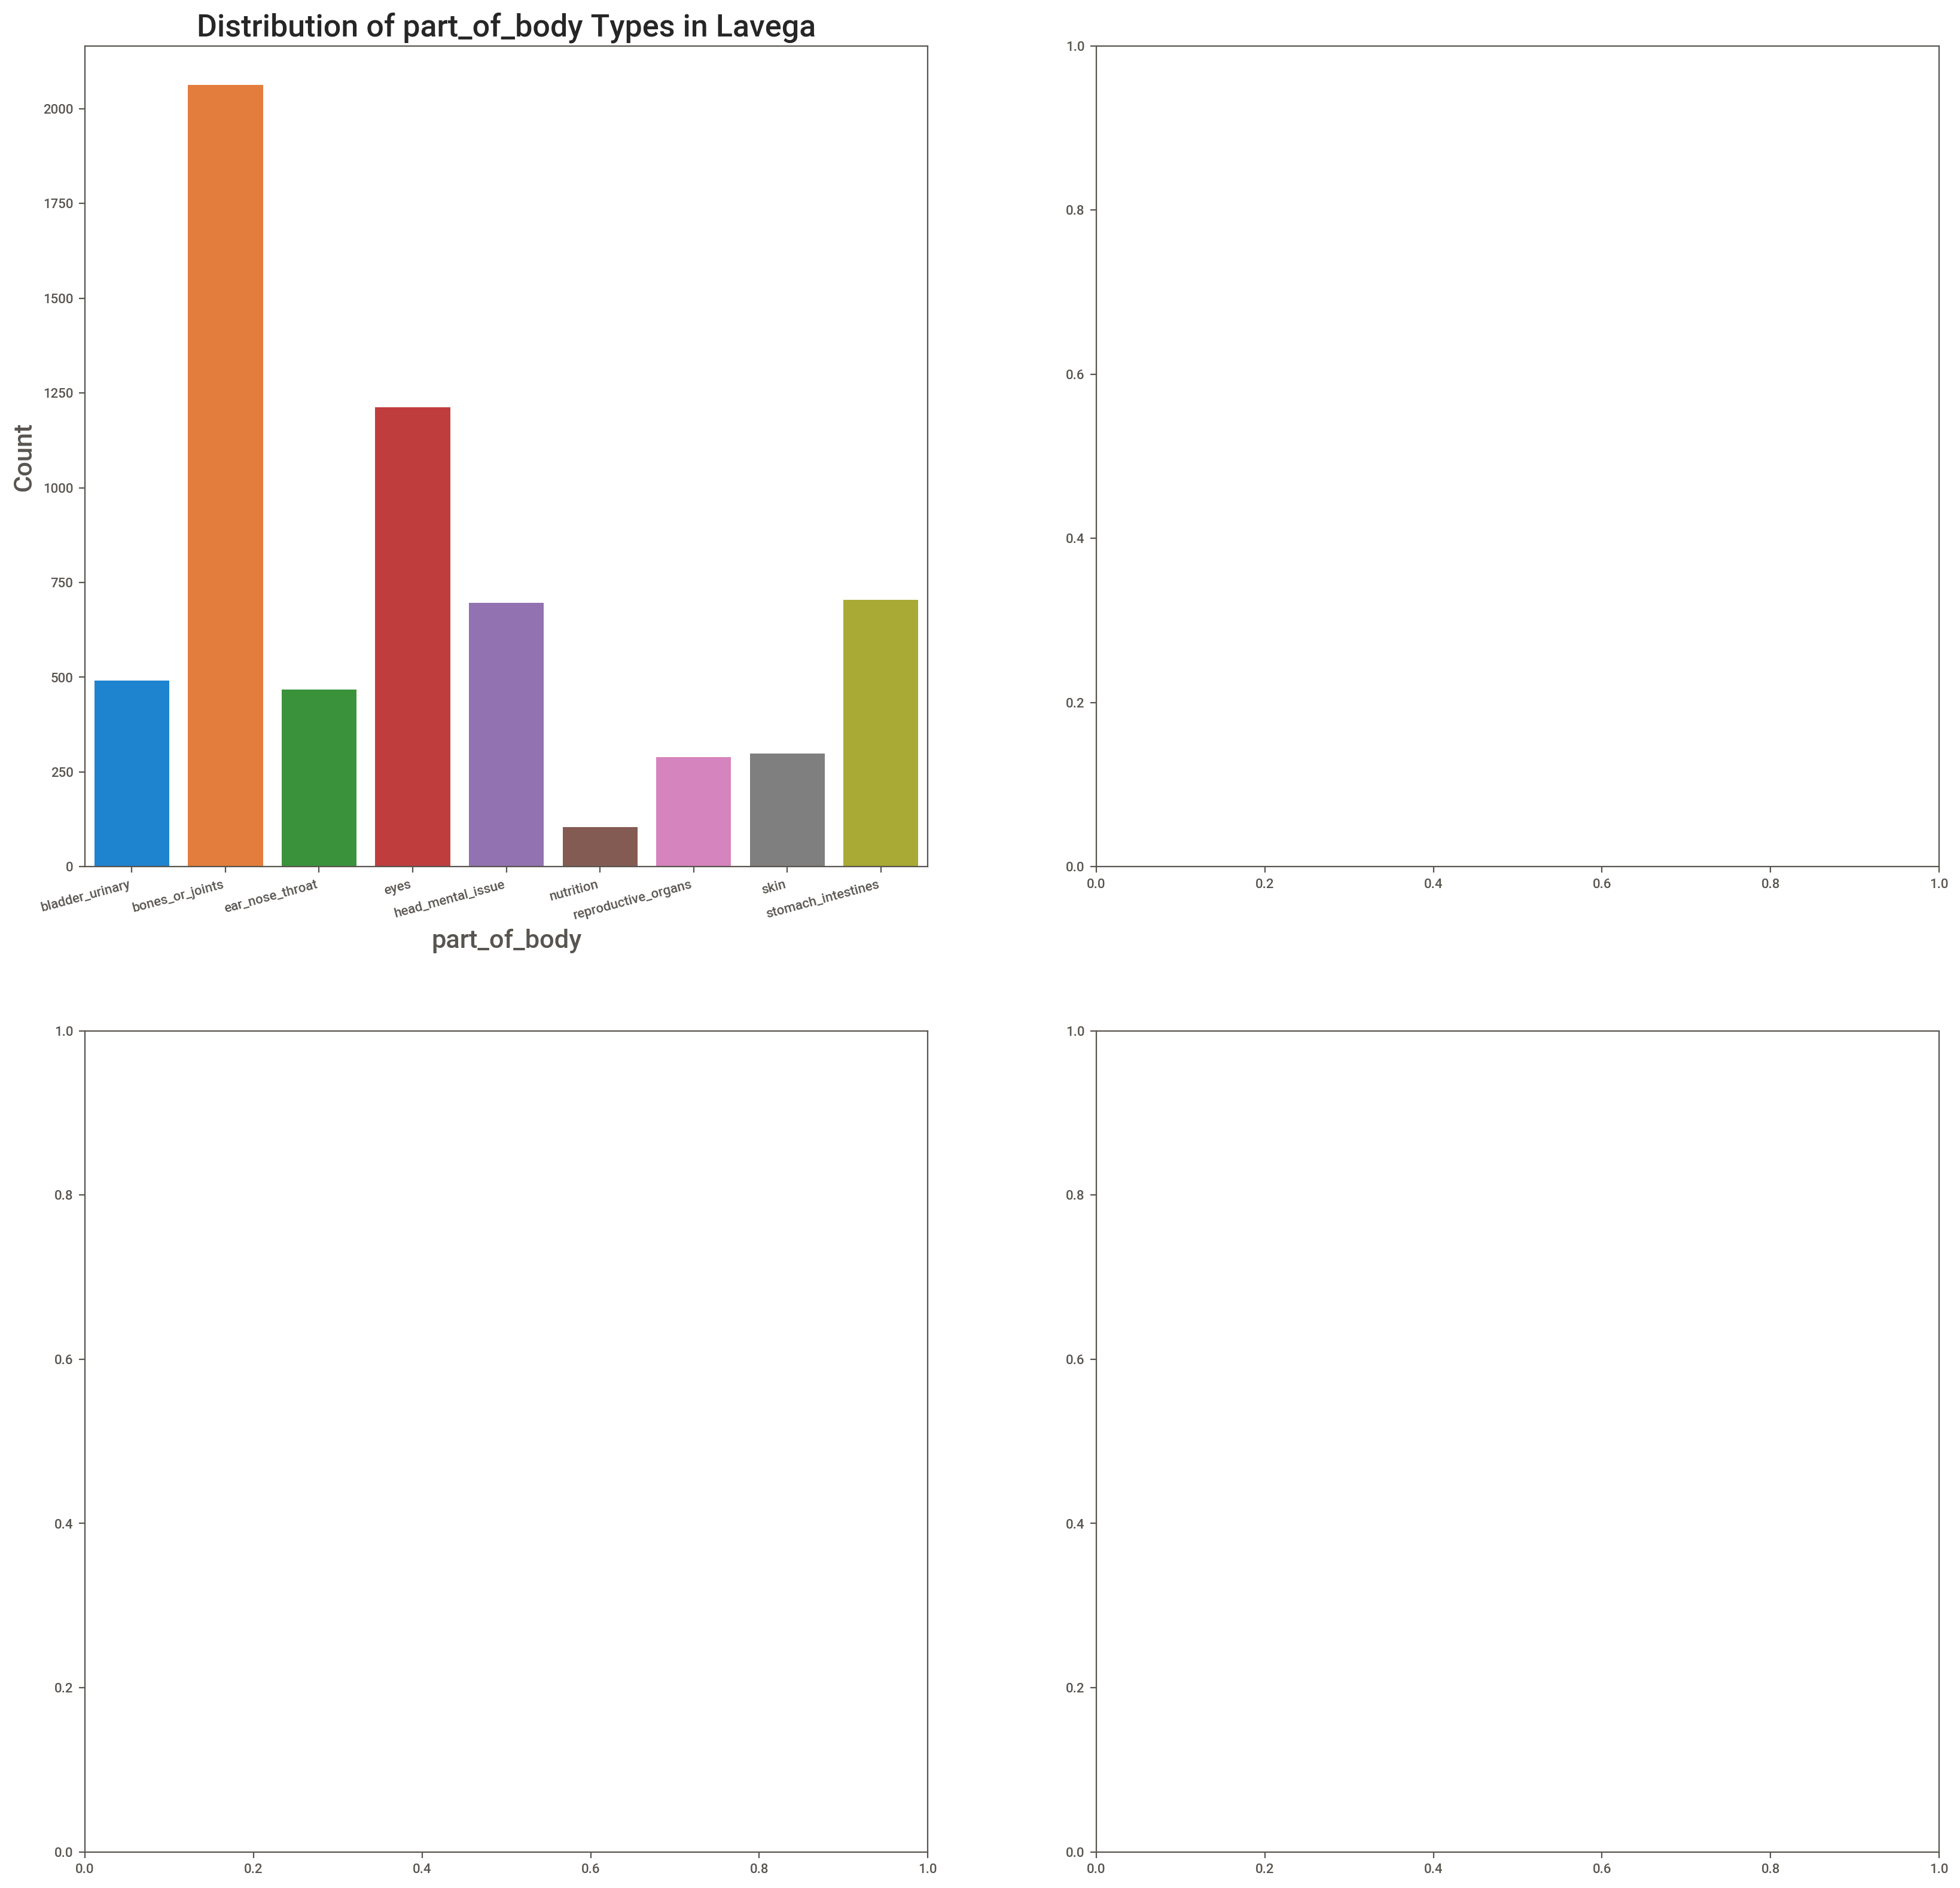

In [50]:
by_province(survey_med, "part_of_body")

In [ ]:
survey_med.province.value_counts()

In [ ]:
sv_report_survey_med = sv.analyze([survey_med, "Survey_med"])
sv_report_survey_med.show_notebook()

### 3. History_env x eval_med

In [ ]:
env_med = history_env.merge(eval_med, how = "inner", on = "objectId")
env_med.head()

In [ ]:
env_med.isna().sum()